In [322]:
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()

# Functions

# Importing Data

In [323]:

def bref_batter(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.batting_stats_bref(year)
            print(f"Batter Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_pitcher(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.pitching_stats_bref(year)
            print(f"Pitcher Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_fielder(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.statcast_outs_above_average(year, "all", 0)
            print(f"Fielding Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def per_game_data(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.season_game_logs(year)
            print(f"Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df




def Main_Scrape(date1,date2):

    batter_data=bref_batter(date1,date2)

    pitcher_data=bref_pitcher(date1,date2)

    fielder_data=bref_fielder(date1,date2)
    batter_data.to_csv('./Lahman_compiled_player_data/batter_data.csv', index=False)
    pitcher_data.to_csv('./Lahman_compiled_player_data/pitcher_data.csv', index=False)
    fielder_data.to_csv('./Lahman_compiled_player_data/fielder_data.csv', index=False)
    return batter_data,fielder_data,pitcher_data



def Main_Import(per_game_path,batter_path,pitcher_path,fielder_path):
    # Save the dataframes to csv files
    per_game_data=pd.read_csv(per_game_path, header=0)
    batter_data=pd.read_csv(batter_path, header=0)
    pitcher_data=pd.read_csv(pitcher_path, header=0)
    fielder_data=pd.read_csv(fielder_path, header=0)
    chad = pyb.chadwick_register(save=True)
    return batter_data,pitcher_data,fielder_data, per_game_data, chad

def fetch_data_bwar(date1, date2, per_game_path):
    import pybaseball as pyb
    import pandas as pd

    # fielder_data = bref_fielder(date1, date2)
    batter_bwar_data = pyb.bwar_bat()
    pitcher_bwar_data = pyb.bwar_pitch()
    per_game_data = pd.read_csv(per_game_path, header=0)
    chad = pyb.chadwick_register(save=True)
    # return fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad
    return batter_bwar_data, pitcher_bwar_data, per_game_data, chad

# Formatting player data

In [324]:
#Remove columns with an NaN above a certain level
def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]
from sklearn.preprocessing import LabelEncoder

#Turn columns with letters in them to numbers
def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df
    
#Turn mlbid into retro id
def process_dataframe(df, index_column, chad, chad_key_column, chad_value_column):
    df = df.set_index(index_column)
    chad_dict = chad.set_index(chad_key_column)[chad_value_column].to_dict()
    df.index = df.index.map(chad_dict)
    return df

# Formatting per game data

In [325]:
def process_per_game_data(per_game_data):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_ID'] = per_game_data['Date'].astype(str) + per_game_data['HmTm'] + per_game_data['VisTm']

    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()

# Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # List of columns to keep
    # Label encode 'ParkID'
    # le=LabelEncoder()

  
    # per_game_data['ParkID'] = le.fit_transform(per_game_data['ParkID'])

    columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns']

    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]

    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)

    
    return per_game_data

def process_vegas_odds(paths):
    
    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_ID'] = xlsx_dataframes['date'].astype(str) + xlsx_dataframes['home_team'] + xlsx_dataframes['visiting_team']
    xlsx_dataframes.set_index('Game_ID', inplace=True)
    xlsx_dataframes.drop(['date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes



def process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded):
    # Replace player_ids with their stats and add new columns for each stat
    for column in player_id_columns:
        if 'PchID' in column:  # If the column is for a pitcher
            stats = per_game_data_reduced[column].map(pitcher_bwar_encoded)
        else:  # If the column is for a batter
            stats = per_game_data_reduced[column].map(batter_bwar_encoded)

        # Add new columns for each stat
        for stat_name in stats.iloc[0].keys():
            per_game_data_reduced[column + '_' + stat_name] = stats.apply(lambda x: x[stat_name] if isinstance(x, dict) else np.nan)

        # Drop the original column
        per_game_data_reduced.drop(column, axis=1, inplace=True)
    
    return per_game_data_reduced

def split_data(per_game_data_reduced, train_year, test_year):
    # Create a mask for the training set
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

    # Split the data into training and testing sets
    X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)

    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']
    
    return X_train, y_train, X_test, y_test

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method, fill_value=0)
    # Fit and transform all columns
    df[:] = imputer.fit_transform(df)
    return df

# Set-up Neural Network

In [326]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data
        X_train, X_valid = X[train_indices], X[valid_indices]
        y_train, y_valid = y[train_indices], y[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

#CALL THE MODEL
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, patience=10, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model

    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

#Luck Accuracy calculation
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients for this
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    return accuracy

# Process Odds

In [327]:


def add_betting_odds(per_game_data, vegas_odds):
    # Map the home odds

        vegas_odds_unique = vegas_odds[~vegas_odds.index.duplicated(keep='first')]
        per_game_data['home_odds'] = per_game_data.index.map(vegas_odds_unique['home_open'])
    # Map the visiting odds
        per_game_data['visiting_odds'] = per_game_data.index.map(vegas_odds_unique['visiting_open'])
        global compare_initial_fill
        compare_initial_fill=per_game_data
        return per_game_data
    
def fill_missing_odds(per_game_data, scrambled_odds):
    # Ensure the indices of both DataFrames match
    scrambled_odds['Game_ID'] = scrambled_odds['date'].astype(str) + scrambled_odds['home_team'] + scrambled_odds['visiting_team']
    scrambled_odds.set_index('Game_ID', inplace=True)
    
    # Create separate Series for home and visiting odds
    
    # Drop duplicates in scrambled_odds based on the index
    scrambled_odds_unique = scrambled_odds[~scrambled_odds.index.duplicated(keep='first')]

    # Create separate Series for home and visiting odds
    home_odds_map = scrambled_odds_unique['home_open']
    visiting_odds_map = scrambled_odds_unique['visiting_open']

    # Update NaN values in per_game_data with values from scrambled_odds
    per_game_data['home_odds'].update(home_odds_map)
    per_game_data['visiting_odds'].update(visiting_odds_map)

    
    global does_it_fill_scramble
    does_it_fill_scramble=per_game_data
    return per_game_data

def fill_remaining_odds(per_game_data, default_value=-110):
        per_game_data['home_odds'] = per_game_data['home_odds'].fillna(default_value)
        per_game_data['visiting_odds'] = per_game_data['visiting_odds'].fillna(default_value)
        return per_game_data

# Predict the outcome of the season and calculate profit

In [328]:
class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance

    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data):
        # Ensure the bettor has enough money in the wallet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]
        
        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]
        
        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']
            
            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds
            
            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)
            
            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)

        return self.wallet
    
def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped



# Call other functions

In [329]:
def evaluate_model_for_year(test_year,train_year_num):
#Training and testing years for the machine learning model
# test_year = '2011'
    train_year = [str(year) for year in range(int(test_year) - train_year_num, int(test_year))]


    #Use this to update data from the websites (has data starting from 2008)
    date1=2008
    date2=2024

    #Do not use this unless you want to go back to the old data
    # batter_data,pitcher_data,fielder_data=Main_Scrape(2008,2024)

    # get the register data and save to disk


    #After scraping the files are saved locally. Also, the per_game_data is found manually and imported
    per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'
    batter_path='./Lahman_compiled_player_data/batter_data.csv'
    pitcher_path='./Lahman_compiled_player_data/pitcher_data.csv'
    fielder_path='./Lahman_compiled_player_data/fielder_data.csv'
    # _,_,fielder_data, per_game_data, chad = Main_Import(per_game_path,batter_path,pitcher_path,fielder_path)


    #New Bwar data scraping
    # fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)
    batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)

    # Use the function to remove columns with more than 40% NaN values
    batter_bwar_data = remove_columns_with_nan(batter_bwar_data, 40)
    pitcher_bwar_data = remove_columns_with_nan(pitcher_bwar_data, 40)
    # fielder_data = remove_columns_with_nan(fielder_data, 40)

    batter_bwar_data = process_dataframe(batter_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
    pitcher_bwar_data = process_dataframe(pitcher_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
    # fielder_data = process_dataframe(fielder_data, 'player_id', chad, 'key_mlbam', 'key_retro')

    batter_bwar_encoded = label_encode(batter_bwar_data)
    batter_bwar_grouped = batter_bwar_encoded.groupby('mlb_ID').mean()
    batter_bwar_reduced=batter_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','player_ID','pitcher'])
    batter_bwar_dict = batter_bwar_reduced.T.to_dict()


    pitcher_bwar_encoded = label_encode(pitcher_bwar_data)
    pitcher_bwar_grouped = pitcher_bwar_encoded.groupby('mlb_ID').mean()
    pitcher_bwar_reduced=pitcher_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','player_ID'])
    pitcher_bwar_dict = pitcher_bwar_reduced.T.to_dict()
    # fielder_encoded = fielder_encoded.T.to_dict()

    vegas_betting_paths='./betting_odds/'
    paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]
    vegas_odds=process_vegas_odds(paths)

    scrambled_betting_paths='all_money_lines.csv'
    scrambled_odds=pd.read_csv(scrambled_betting_paths)
    #Drops unnecessary columns
    per_game_data_reduced = process_per_game_data(per_game_data)
    test_purposes=process_per_game_data(per_game_data)

    

# Assuming per_game_data_with_odds is already defined and has 'home_odds' and 'visiting_odds'
# Also assuming scrambled_odds is defined and has 'Game_ID' as its index



# Assuming per_game_data_reduced and vegas_odds are already defined and have 'Game_ID' as their index
    per_game_data_with_odds = add_betting_odds(per_game_data_reduced, vegas_odds)
# Fill rows that have missing NaNs
    per_game_data_filled_odds = fill_missing_odds(per_game_data_with_odds, scrambled_odds)
# Assuming per_game_data_filled_odds is already defined and may have NaN values
    per_game_data_final_odds = fill_remaining_odds(per_game_data_filled_odds)
  
    global per_game_odds
    per_game_odds=per_game_data_final_odds
    # List of columns containing player_ids
    player_id_columns = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']


    #replaces player_ids with their player_stats
    # for_test_purposes = process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded)
    per_game_data_reduced = process_player_data(per_game_data_final_odds, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
    test_purposes = process_player_data(test_purposes, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
    #Removes columns with more than 40%
    per_game_data_reduced = remove_columns_with_nan(per_game_data_reduced, 40)
    #replaces nan with 0s

    per_game_data_imputed=Impute(per_game_data_reduced,'mean')

    #splits the data into 
    X_train, y_train, X_test, y_test = split_data(per_game_data_imputed, train_year, test_year)
    #my code is bad so the model needs to be called again after the cross validater
    model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
    

    # print("Cross-validation scores: ", scores)
    # print("Cross-validation scores average: ", np.mean(scores))
    # print("Standard deviation of cross-validation score: ", np.std(scores))
    # model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)

    train_dataset = vector_dataset(X_train, y_train)
    test_dataset = vector_dataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # optimizer = optim.Adam(model.parameters(), lr=0.0005)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()

    conf_matrix, class_report=train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion)





    ok, bets, skipped = predict_game_outcome(X_test.index, X_test.values, model, True, 10, 3)

    better = Better()  # Create a Bettor instance with an initial wallet of 1000
    # for game_id, bet_on_home_team in ok:
    #     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)
    for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
        better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_data_imputed)





    scores = cross_validate(model, X_train.values, y_train.values)


    test_accuracy = calculate_accuracy(model, test_loader)
   

    return better.wallet, better.wallet_history, scores, test_accuracy, class_report, conf_matrix

# Calculate profit for all years and plot.

In [330]:
def run_experiment(num_iterations,train_year_num):
    all_results = []
    for _ in range(num_iterations):
        yearly_results = {}
        for year in range(2015, 2024):
            wallet, wallet_history, scores, test_accuracy, class_report, conf_matrix = evaluate_model_for_year(str(year), train_year_num)
            yearly_results[year] = {"wallet": wallet, "wallet_history": wallet_history, "scores": scores, "test_accuracy": test_accuracy, "class_report": class_report, "conf_matrix": conf_matrix}
        all_results.append(yearly_results)
    return all_results

#Aggregated stats for all years
def display_average_results(all_results):
    # Initialize lists to store all metrics
    all_wallets = []
    all_mean_scores = []
    all_test_accuracies = []
    all_conf_matrices = []
    all_class_reports = []

    for iteration, results in enumerate(all_results):
        iteration_wallets = []
        iteration_mean_scores = []
        iteration_test_accuracies = []
        iteration_conf_matrices = []
        iteration_class_reports = []
        for year, data in results.items():
            iteration_wallets.append(data['wallet'])
            iteration_mean_scores.append(np.mean(data['scores']))
            iteration_test_accuracies.append(data['test_accuracy'])
            iteration_conf_matrices.append(data['conf_matrix'])
            iteration_class_reports.append(data['class_report'])
        all_wallets.append(iteration_wallets)
        all_mean_scores.append(iteration_mean_scores)
        all_test_accuracies.append(iteration_test_accuracies)
        all_conf_matrices.append(iteration_conf_matrices)
        all_class_reports.append(iteration_class_reports)

    # Calculate the average for each metric over all iterations
    avg_wallet = np.mean(all_wallets)
    avg_mean_score = np.mean(all_mean_scores)
    avg_test_accuracy = np.mean(all_test_accuracies)
    # avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
    # # For classification report, we can't calculate mean directly, so we'll just display them
    # all_class_reports = np.array(all_class_reports)

    print(f"Average final wallet balance over all iterations: {avg_wallet}")
    print(f"Average mean score over all iterations: {avg_mean_score}")
    print(f"Average test accuracy over all iterations: {avg_test_accuracy}")
    # print(f"Average confusion matrix over all iterations: \n{avg_conf_matrix}")
    # print(f"Classification reports for all iterations: \n{all_class_reports}")

# Call the function
def display_results(all_results):
    for iteration, results in enumerate(all_results):
        print(f"Iteration: {iteration+1}")
        for year, data in results.items():
            print(f"Year: {year}")
            print(f"Final Wallet Balance: {data['wallet']}")
            plt.plot(data['wallet_history'])
            plt.xlabel('Game Number')
            plt.ylabel('Wallet Balance')
            plt.title(f'Wallet Balance for Year {year} in Iteration {iteration+1}')
            plt.show()
            print(f"Minimum Wallet Balance: {min(data['wallet_history'])}\n")

        mean_scores = {}
        for year, data in results.items():
            mean_scores[year] = np.mean(data['scores'])

        mean_of_all_years = np.mean(list(mean_scores.values()))
        print(f"Mean score of all years in Iteration {iteration+1}: {mean_of_all_years}")

        #
        for year, data in results.items():
            print(f"Year: {year}")
            print(f"Final Wallet Balance: {data['wallet']}")
            plt.plot(data['wallet_history'])
            plt.xlabel('Game Number')
            plt.ylabel('Wallet Balance')
            plt.title(f'Wallet Balance for Year {year}')
            plt.show()
            print(f"Minimum Wallet Balance: {min(data['wallet_history'])}\n")

        mean_scores = {}
        for year, data in results.items():
            mean_scores[year] = np.mean(data['scores'])

        mean_of_all_years = np.mean(list(mean_scores.values()))

        #Combined wallet balance
        for year, data in results.items():
            plt.plot(data['wallet_history'], label=f'Year {year}')

        plt.xlabel('Game Number')
        plt.ylabel('Wallet Balance')
        plt.title('Wallet Balance for All Years')
        plt.legend()
        plt.show()

        # Initialize lists to store all scores and test accuracies
        all_scores = []
        all_test_accuracies = []

# Loop through all results and extract scores and test accuracies
        for iteration_results in all_results:
            for year, data in iteration_results.items():
                all_scores.extend(data['scores'])  # Assuming 'scores' is a list
                all_test_accuracies.append(data['test_accuracy'])

        # Calculate the average and standard deviation of cross-validation scores
        mean_scores = np.mean(all_scores)
        std_scores = np.std(all_scores)

        # Calculate the average test accuracy
        mean_test_accuracy = np.mean(all_test_accuracies)

        print("Cross-validation scores: ", all_scores)
        print("Cross-validation scores average: ", mean_scores)
        print("Standard deviation of cross-validation score: ", std_scores)
        print(f'Test Accuracy: {mean_test_accuracy * 100:.2f}%')


        # Initialize an empty list to store the combined wallet history
        combined_wallet_history = []

        # Loop over each year's data and extend the combined wallet history with each year's wallet history
        for data in results.values():
            combined_wallet_history.extend(data['wallet_history'])

        # Plot the combined wallet balance over time
        plt.plot(combined_wallet_history)
        plt.xlabel('Game Number')
        plt.ylabel('Wallet Balance')
        plt.title('Combined Wallet Balance for All Years')
        plt.show()

        # Initialize an empty list to store the combined wallet history
        combined_wallet_history = []

        # Initialize a variable to store the ending balance of the previous year
        previous_year_end_balance = 0

        # Loop over each year's data
        for data in results.values():
            # Add the ending balance of the previous year to the wallet history of the current year
            adjusted_wallet_history = [balance + previous_year_end_balance for balance in data['wallet_history']]
            
            # Extend the combined wallet history with the adjusted wallet history of the current year
            combined_wallet_history.extend(adjusted_wallet_history)
            
            # Update the ending balance of the previous year
            previous_year_end_balance = adjusted_wallet_history[-1]

        # Print the maximum and minimum values of the combined wallet history
        print(f"Maximum Wallet Balance: {max(combined_wallet_history)}")
        print(f"Minimum Wallet Balance: {min(combined_wallet_history)}")

        # Plot the combined wallet balance over time
        plt.plot(combined_wallet_history)
        plt.xlabel('Game Number')
        plt.ylabel('Wallet Balance')
        plt.title('Combined Wallet Balance for All Years')
        plt.show()

        for year, data in results.items():
            print(f"Year: {year}")
            print("Confusion Matrix:")
            print(data['conf_matrix'])
            print("Classification Report:")
            print(data['class_report'])

            from sklearn.metrics import confusion_matrix, classification_report


        #
        # Initialize lists to store all true and predicted labels
        all_true_labels = []
        all_pred_labels = []

        # Loop over each year's data
        for data in results.values():
            # Extend the lists with the true and predicted labels of the current year
            all_true_labels.extend(data['true_labels'])
            all_pred_labels.extend(data['pred_labels'])

        # Calculate the overall confusion matrix and classification report
        overall_conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
        overall_class_report = classification_report(all_true_labels, all_pred_labels)

        print("Overall Confusion Matrix:")
        print(overall_conf_matrix)
        print("Overall Classification Report:")
        print(overall_class_report)





# Call the function



# Call the function with the number of runs you want


In [331]:
# results = {}
# for year in range(2015, 2024):
#     wallet, wallet_history, scores, test_accuracy, class_report, conf_matrix = evaluate_model_for_year(str(year))
#     results[year] = {"wallet": wallet, "wallet_history": wallet_history, "scores": scores, "test_accuracy": test_accuracy, "class_report": class_report, "conf_matrix": conf_matrix}
all_results_9 = run_experiment(3,8)

# print(wallet)
# # Plot the wallet balance over time
# plt.plot(wallet_history)
# plt.xlabel('Game Number')
# plt.ylabel('Wallet Balance')
# plt.show()
# print(min(wallet_history))

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -120            100

[28006 rows x 2 columns]


Epoch 1: 100%|██████████| 318/318 [00:01<00:00, 224.28it/s]


Training Loss: 0.9067515427211545
Validation Loss: 0.6933362280067644


Epoch 2: 100%|██████████| 318/318 [00:01<00:00, 223.48it/s]


Training Loss: 0.6964233305844121
Validation Loss: 0.6866360259683508


Epoch 3: 100%|██████████| 318/318 [00:01<00:00, 226.59it/s]


Training Loss: 0.6907645891297538
Validation Loss: 0.6834777075993387


Epoch 4: 100%|██████████| 318/318 [00:01<00:00, 227.20it/s]


Training Loss: 0.6871877520714166
Validation Loss: 0.6855361398897672


Epoch 5: 100%|██████████| 318/318 [00:01<00:00, 225.15it/s]


Training Loss: 0.6855709466544337
Validation Loss: 0.6837411977742848


Epoch 6: 100%|██████████| 318/318 [00:01<00:00, 221.16it/s]


Training Loss: 0.684317188255442
Validation Loss: 0.6838906642637754


Epoch 7: 100%|██████████| 318/318 [00:01<00:00, 223.37it/s]


Training Loss: 0.6838057925866085
Validation Loss: 0.6822561307957298


Epoch 8: 100%|██████████| 318/318 [00:01<00:00, 216.65it/s]


Training Loss: 0.6840323485293478
Validation Loss: 0.6871512563605058


Epoch 9: 100%|██████████| 318/318 [00:01<00:00, 217.53it/s]


Training Loss: 0.6839228004404584
Validation Loss: 0.684118429296895


Epoch 10: 100%|██████████| 318/318 [00:01<00:00, 228.01it/s]


Training Loss: 0.6838025077708862
Validation Loss: 0.6841630606274856


Epoch 11: 100%|██████████| 318/318 [00:01<00:00, 229.18it/s]


Training Loss: 0.6822504088188868
Validation Loss: 0.6815504055274161


Epoch 12: 100%|██████████| 318/318 [00:01<00:00, 217.76it/s]


Training Loss: 0.6822095222818026
Validation Loss: 0.685125187823647


Epoch 13: 100%|██████████| 318/318 [00:01<00:00, 202.91it/s]


Training Loss: 0.6832633470214388
Validation Loss: 0.682476166047548


Epoch 14: 100%|██████████| 318/318 [00:01<00:00, 187.06it/s]


Training Loss: 0.6813542912216306
Validation Loss: 0.681625673645421


Epoch 15: 100%|██████████| 318/318 [00:01<00:00, 205.96it/s]


Training Loss: 0.6815230765807554
Validation Loss: 0.6824847224511599


Epoch 16: 100%|██████████| 318/318 [00:01<00:00, 205.90it/s]


Training Loss: 0.6810302016495159
Validation Loss: 0.6842182247262252


Epoch 17: 100%|██████████| 318/318 [00:01<00:00, 211.67it/s]


Training Loss: 0.6800507052139666
Validation Loss: 0.6819583397162589


Epoch 18: 100%|██████████| 318/318 [00:01<00:00, 203.85it/s]


Training Loss: 0.6806975142011102
Validation Loss: 0.6821960697048589


Epoch 19: 100%|██████████| 318/318 [00:01<00:00, 196.72it/s]


Training Loss: 0.680959348783553
Validation Loss: 0.6843531665049101


Epoch 20: 100%|██████████| 318/318 [00:01<00:00, 188.05it/s]


Training Loss: 0.6811838374947602
Validation Loss: 0.682421652894271


Epoch 21: 100%|██████████| 318/318 [00:01<00:00, 180.53it/s]


Training Loss: 0.6802255353837643
Validation Loss: 0.680708718927283


Epoch 22: 100%|██████████| 318/318 [00:01<00:00, 189.76it/s]


Training Loss: 0.67884358145156
Validation Loss: 0.6825610493358812


Epoch 23: 100%|██████████| 318/318 [00:01<00:00, 171.31it/s]


Training Loss: 0.6800625106823519
Validation Loss: 0.6826621137167278


Epoch 24: 100%|██████████| 318/318 [00:01<00:00, 175.18it/s]


Training Loss: 0.6793594261010488
Validation Loss: 0.6832534372806549


Epoch 25: 100%|██████████| 318/318 [00:01<00:00, 190.61it/s]


Training Loss: 0.6797176267740861
Validation Loss: 0.6819803369672675


Epoch 26: 100%|██████████| 318/318 [00:01<00:00, 172.90it/s]


Training Loss: 0.6792615056037903
Validation Loss: 0.6829128594774949


Epoch 27: 100%|██████████| 318/318 [00:01<00:00, 188.06it/s]


Training Loss: 0.6779845398177141
Validation Loss: 0.6846626400947571


Epoch 28: 100%|██████████| 318/318 [00:01<00:00, 208.38it/s]


Training Loss: 0.6795044115879251
Validation Loss: 0.6832165420055389


Epoch 29: 100%|██████████| 318/318 [00:02<00:00, 131.69it/s]


Training Loss: 0.6776787816728436
Validation Loss: 0.6831542786798979


Epoch 30: 100%|██████████| 318/318 [00:02<00:00, 134.34it/s]


Training Loss: 0.6764592434625206
Validation Loss: 0.6825796757873736


Epoch 31: 100%|██████████| 318/318 [00:01<00:00, 190.16it/s]


Training Loss: 0.6765717886528879
Validation Loss: 0.6823836188567313
Early stopping triggered
Confusion Matrix:
[[ 345  769]
 [ 286 1029]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.31      0.40      1114
           1       0.57      0.78      0.66      1315

    accuracy                           0.57      2429
   macro avg       0.56      0.55      0.53      2429
weighted avg       0.56      0.57      0.54      2429

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL    

Epoch 1: 100%|██████████| 317/317 [00:01<00:00, 218.36it/s]


Training Loss: 0.9120067391861877
Validation Loss: 0.688832916711506


Epoch 2: 100%|██████████| 317/317 [00:01<00:00, 202.84it/s]


Training Loss: 0.6943631033039995
Validation Loss: 0.6859739626708784


Epoch 3: 100%|██████████| 317/317 [00:01<00:00, 187.18it/s]


Training Loss: 0.6896572214571836
Validation Loss: 0.687293247172707


Epoch 4: 100%|██████████| 317/317 [00:01<00:00, 187.72it/s]


Training Loss: 0.6894116390390727
Validation Loss: 0.6872400045394897


Epoch 5: 100%|██████████| 317/317 [00:02<00:00, 150.04it/s]


Training Loss: 0.6881477197262015
Validation Loss: 0.6861971177552876


Epoch 6: 100%|██████████| 317/317 [00:01<00:00, 184.58it/s]


Training Loss: 0.6873521368586303
Validation Loss: 0.6813480305044275


Epoch 7: 100%|██████████| 317/317 [00:01<00:00, 180.73it/s]


Training Loss: 0.6854344125049724
Validation Loss: 0.6810324944947895


Epoch 8: 100%|██████████| 317/317 [00:01<00:00, 173.15it/s]


Training Loss: 0.6848048496321549
Validation Loss: 0.6899184176796361


Epoch 9: 100%|██████████| 317/317 [00:01<00:00, 193.26it/s]


Training Loss: 0.6847812200570332
Validation Loss: 0.6822125927398079


Epoch 10: 100%|██████████| 317/317 [00:01<00:00, 202.05it/s]


Training Loss: 0.683791419685075
Validation Loss: 0.6823634128821524


Epoch 11: 100%|██████████| 317/317 [00:01<00:00, 190.62it/s]


Training Loss: 0.6837979688629366
Validation Loss: 0.6792106424507341


Epoch 12: 100%|██████████| 317/317 [00:01<00:00, 179.80it/s]


Training Loss: 0.6834681989266669
Validation Loss: 0.6810717018027055


Epoch 13: 100%|██████████| 317/317 [00:01<00:00, 207.20it/s]


Training Loss: 0.6826825619496005
Validation Loss: 0.6822852068825772


Epoch 14: 100%|██████████| 317/317 [00:01<00:00, 177.90it/s]


Training Loss: 0.6818395512713242
Validation Loss: 0.6811671680525729


Epoch 15: 100%|██████████| 317/317 [00:01<00:00, 168.80it/s]


Training Loss: 0.6814047182772062
Validation Loss: 0.6865269902505373


Epoch 16: 100%|██████████| 317/317 [00:01<00:00, 182.19it/s]


Training Loss: 0.6818534810836383
Validation Loss: 0.6806153529568723


Epoch 17: 100%|██████████| 317/317 [00:01<00:00, 175.01it/s]


Training Loss: 0.6811085772063078
Validation Loss: 0.6838296008737463


Epoch 18: 100%|██████████| 317/317 [00:01<00:00, 175.62it/s]


Training Loss: 0.680641448648194
Validation Loss: 0.6778970611722845


Epoch 19: 100%|██████████| 317/317 [00:01<00:00, 187.47it/s]


Training Loss: 0.6808035871960011
Validation Loss: 0.6796669144379465


Epoch 20: 100%|██████████| 317/317 [00:01<00:00, 203.35it/s]


Training Loss: 0.6799506152089838
Validation Loss: 0.6828869142030415


Epoch 21: 100%|██████████| 317/317 [00:01<00:00, 175.39it/s]


Training Loss: 0.679472704039011
Validation Loss: 0.679193460627606


Epoch 22: 100%|██████████| 317/317 [00:01<00:00, 174.16it/s]


Training Loss: 0.6807106740843234
Validation Loss: 0.679849657573198


Epoch 23: 100%|██████████| 317/317 [00:01<00:00, 171.03it/s]


Training Loss: 0.6799711699741496
Validation Loss: 0.6783900856971741


Epoch 24: 100%|██████████| 317/317 [00:02<00:00, 154.14it/s]


Training Loss: 0.6785267040556537
Validation Loss: 0.6796958995492834


Epoch 25: 100%|██████████| 317/317 [00:02<00:00, 149.35it/s]


Training Loss: 0.6793797736288245
Validation Loss: 0.6819090529492027


Epoch 26: 100%|██████████| 317/317 [00:02<00:00, 144.18it/s]


Training Loss: 0.6785521986732723
Validation Loss: 0.6820059575532612


Epoch 27: 100%|██████████| 317/317 [00:01<00:00, 172.30it/s]


Training Loss: 0.6784564187098001
Validation Loss: 0.6787637268242083


Epoch 28: 100%|██████████| 317/317 [00:01<00:00, 184.82it/s]


Training Loss: 0.6788681420241997
Validation Loss: 0.6798704360660753
Early stopping triggered
Confusion Matrix:
[[425 716]
 [340 947]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.37      0.45      1141
           1       0.57      0.74      0.64      1287

    accuracy                           0.57      2428
   macro avg       0.56      0.55      0.54      2428
weighted avg       0.56      0.57      0.55      2428

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 310/310 [00:01<00:00, 195.64it/s]


Training Loss: 0.8783504095769697
Validation Loss: 0.6974372377521113


Epoch 2: 100%|██████████| 310/310 [00:01<00:00, 176.03it/s]


Training Loss: 0.696706848759805
Validation Loss: 0.6866604372074729


Epoch 3: 100%|██████████| 310/310 [00:01<00:00, 178.88it/s]


Training Loss: 0.6875697981926703
Validation Loss: 0.6883778289744729


Epoch 4: 100%|██████████| 310/310 [00:01<00:00, 194.33it/s]


Training Loss: 0.6865282760512444
Validation Loss: 0.6867389726011377


Epoch 5: 100%|██████████| 310/310 [00:01<00:00, 199.14it/s]


Training Loss: 0.6843658999089272
Validation Loss: 0.6856529398968345


Epoch 6: 100%|██████████| 310/310 [00:01<00:00, 180.08it/s]


Training Loss: 0.6841085972324494
Validation Loss: 0.6853944800401989


Epoch 7: 100%|██████████| 310/310 [00:01<00:00, 180.78it/s]


Training Loss: 0.6834195081264742
Validation Loss: 0.6867209610186125


Epoch 8: 100%|██████████| 310/310 [00:01<00:00, 169.41it/s]


Training Loss: 0.6817605887689898
Validation Loss: 0.6896768745623136


Epoch 9: 100%|██████████| 310/310 [00:01<00:00, 170.02it/s]


Training Loss: 0.6814077206196324
Validation Loss: 0.6846758880113301


Epoch 10: 100%|██████████| 310/310 [00:01<00:00, 167.46it/s]


Training Loss: 0.681649269980769
Validation Loss: 0.6849542432709744


Epoch 11: 100%|██████████| 310/310 [00:01<00:00, 166.24it/s]


Training Loss: 0.6817660199057671
Validation Loss: 0.685624045761008


Epoch 12: 100%|██████████| 310/310 [00:01<00:00, 171.06it/s]


Training Loss: 0.6816746294498444
Validation Loss: 0.6845423312563645


Epoch 13: 100%|██████████| 310/310 [00:01<00:00, 168.66it/s]


Training Loss: 0.680558156582617
Validation Loss: 0.6843668159685636


Epoch 14: 100%|██████████| 310/310 [00:01<00:00, 172.00it/s]


Training Loss: 0.6809630930423737
Validation Loss: 0.6873514793421093


Epoch 15: 100%|██████████| 310/310 [00:01<00:00, 169.58it/s]


Training Loss: 0.6805914240498696
Validation Loss: 0.6891299360676816


Epoch 16: 100%|██████████| 310/310 [00:01<00:00, 164.10it/s]


Training Loss: 0.679835569858551
Validation Loss: 0.6845307757979945


Epoch 17: 100%|██████████| 310/310 [00:01<00:00, 165.98it/s]


Training Loss: 0.6799997050915995
Validation Loss: 0.6872280632194719


Epoch 18: 100%|██████████| 310/310 [00:01<00:00, 166.35it/s]


Training Loss: 0.6797865827237406
Validation Loss: 0.6927741969886579


Epoch 19: 100%|██████████| 310/310 [00:01<00:00, 168.14it/s]


Training Loss: 0.6806486864243785
Validation Loss: 0.6837241304548163


Epoch 20: 100%|██████████| 310/310 [00:01<00:00, 163.97it/s]


Training Loss: 0.678898823453534
Validation Loss: 0.6850604665906805


Epoch 21: 100%|██████████| 310/310 [00:01<00:00, 167.97it/s]


Training Loss: 0.6798603561616713
Validation Loss: 0.6828627084430895


Epoch 22: 100%|██████████| 310/310 [00:01<00:00, 160.06it/s]


Training Loss: 0.6775292602277572
Validation Loss: 0.6840557126622451


Epoch 23: 100%|██████████| 310/310 [00:01<00:00, 171.90it/s]


Training Loss: 0.6781285751250482
Validation Loss: 0.6850438353262449


Epoch 24: 100%|██████████| 310/310 [00:01<00:00, 167.94it/s]


Training Loss: 0.6779393013446562
Validation Loss: 0.6850853625096773


Epoch 25: 100%|██████████| 310/310 [00:01<00:00, 164.49it/s]


Training Loss: 0.6775832201203992
Validation Loss: 0.6831321575139698


Epoch 26: 100%|██████████| 310/310 [00:01<00:00, 155.85it/s]


Training Loss: 0.6772237404700249
Validation Loss: 0.6849210560321808


Epoch 27: 100%|██████████| 310/310 [00:01<00:00, 165.74it/s]


Training Loss: 0.6768715373931392
Validation Loss: 0.685804086296182


Epoch 28: 100%|██████████| 310/310 [00:01<00:00, 167.74it/s]


Training Loss: 0.6769330784197777
Validation Loss: 0.6841854970706137


Epoch 29: 100%|██████████| 310/310 [00:01<00:00, 166.56it/s]


Training Loss: 0.6759137736212822
Validation Loss: 0.6872551911755612


Epoch 30: 100%|██████████| 310/310 [00:01<00:00, 165.98it/s]


Training Loss: 0.6753083132928418
Validation Loss: 0.6828565456365284


Epoch 31: 100%|██████████| 310/310 [00:01<00:00, 164.31it/s]


Training Loss: 0.6753483005108372
Validation Loss: 0.6845870865018744


Epoch 32: 100%|██████████| 310/310 [00:01<00:00, 161.83it/s]


Training Loss: 0.6745022846806434
Validation Loss: 0.6837761904063978


Epoch 33: 100%|██████████| 310/310 [00:01<00:00, 165.70it/s]


Training Loss: 0.6746580629579483
Validation Loss: 0.6863654710744557


Epoch 34: 100%|██████████| 310/310 [00:01<00:00, 177.38it/s]


Training Loss: 0.673978070482131
Validation Loss: 0.6919435764613905


Epoch 35: 100%|██████████| 310/310 [00:01<00:00, 165.07it/s]


Training Loss: 0.6715610930996556
Validation Loss: 0.688436265054502


Epoch 36: 100%|██████████| 310/310 [00:01<00:00, 164.85it/s]


Training Loss: 0.6729536614110393
Validation Loss: 0.6851193387257425


Epoch 37: 100%|██████████| 310/310 [00:01<00:00, 168.11it/s]


Training Loss: 0.6709355563886704
Validation Loss: 0.6896874512496748


Epoch 38: 100%|██████████| 310/310 [00:01<00:00, 167.04it/s]


Training Loss: 0.6710720016110328
Validation Loss: 0.6910377536949358


Epoch 39: 100%|██████████| 310/310 [00:01<00:00, 164.00it/s]


Training Loss: 0.6696519732475281
Validation Loss: 0.6972614950255344


Epoch 40: 100%|██████████| 310/310 [00:01<00:00, 160.05it/s]


Training Loss: 0.6681840425537479
Validation Loss: 0.6906558243851912
Early stopping triggered
Confusion Matrix:
[[ 358  760]
 [ 294 1018]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.32      0.40      1118
           1       0.57      0.78      0.66      1312

    accuracy                           0.57      2430
   macro avg       0.56      0.55      0.53      2430
weighted avg       0.56      0.57      0.54      2430

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL    

Epoch 1: 100%|██████████| 304/304 [00:01<00:00, 160.24it/s]


Training Loss: 0.8734982597984766
Validation Loss: 0.6847748897577587


Epoch 2: 100%|██████████| 304/304 [00:01<00:00, 164.93it/s]


Training Loss: 0.6923144487173933
Validation Loss: 0.6812456579584825


Epoch 3: 100%|██████████| 304/304 [00:01<00:00, 168.14it/s]


Training Loss: 0.6889498429863077
Validation Loss: 0.6861239844246915


Epoch 4: 100%|██████████| 304/304 [00:01<00:00, 170.47it/s]


Training Loss: 0.6861833104569661
Validation Loss: 0.6807674044056943


Epoch 5: 100%|██████████| 304/304 [00:01<00:00, 173.44it/s]


Training Loss: 0.6858600699587872
Validation Loss: 0.6812246222245065


Epoch 6: 100%|██████████| 304/304 [00:01<00:00, 176.35it/s]


Training Loss: 0.6840183511376381
Validation Loss: 0.6835638347424959


Epoch 7: 100%|██████████| 304/304 [00:01<00:00, 171.15it/s]


Training Loss: 0.6835292046399493
Validation Loss: 0.6861961844720339


Epoch 8: 100%|██████████| 304/304 [00:01<00:00, 173.90it/s]


Training Loss: 0.6842781746465909
Validation Loss: 0.6821615084221488


Epoch 9: 100%|██████████| 304/304 [00:01<00:00, 171.56it/s]


Training Loss: 0.6836533518998247
Validation Loss: 0.6827476322650909


Epoch 10: 100%|██████████| 304/304 [00:01<00:00, 163.12it/s]


Training Loss: 0.6816920398881561
Validation Loss: 0.678256055242137


Epoch 11: 100%|██████████| 304/304 [00:01<00:00, 164.35it/s]


Training Loss: 0.683198300043219
Validation Loss: 0.6815049993364435


Epoch 12: 100%|██████████| 304/304 [00:01<00:00, 156.64it/s]


Training Loss: 0.6813927704566404
Validation Loss: 0.678530321309441


Epoch 13: 100%|██████████| 304/304 [00:01<00:00, 162.77it/s]


Training Loss: 0.6827698506807026
Validation Loss: 0.6863492460627305


Epoch 14: 100%|██████████| 304/304 [00:01<00:00, 165.11it/s]


Training Loss: 0.6826021681098562
Validation Loss: 0.6831809282302856


Epoch 15: 100%|██████████| 304/304 [00:01<00:00, 164.41it/s]


Training Loss: 0.6816944174076381
Validation Loss: 0.6906142375971142


Epoch 16: 100%|██████████| 304/304 [00:01<00:00, 167.06it/s]


Training Loss: 0.6808751325466131
Validation Loss: 0.6781707358987707


Epoch 17: 100%|██████████| 304/304 [00:01<00:00, 165.08it/s]


Training Loss: 0.6804374481894468
Validation Loss: 0.6862110448511023


Epoch 18: 100%|██████████| 304/304 [00:01<00:00, 163.17it/s]


Training Loss: 0.6801808135289895
Validation Loss: 0.6858631152855722


Epoch 19: 100%|██████████| 304/304 [00:01<00:00, 168.07it/s]


Training Loss: 0.6805981411353538
Validation Loss: 0.6821416334102028


Epoch 20: 100%|██████████| 304/304 [00:01<00:00, 164.84it/s]


Training Loss: 0.679243881647524
Validation Loss: 0.6825398363565144


Epoch 21: 100%|██████████| 304/304 [00:01<00:00, 155.38it/s]


Training Loss: 0.6805240133483159
Validation Loss: 0.6783069434918856


Epoch 22: 100%|██████████| 304/304 [00:01<00:00, 163.92it/s]


Training Loss: 0.6776669980271867
Validation Loss: 0.6839119807669991


Epoch 23: 100%|██████████| 304/304 [00:01<00:00, 161.08it/s]


Training Loss: 0.6781228423902863
Validation Loss: 0.6827091433499989


Epoch 24: 100%|██████████| 304/304 [00:01<00:00, 162.88it/s]


Training Loss: 0.6790542767236107
Validation Loss: 0.6899074472879109


Epoch 25: 100%|██████████| 304/304 [00:01<00:00, 165.57it/s]


Training Loss: 0.6785897600807642
Validation Loss: 0.685084730386734


Epoch 26: 100%|██████████| 304/304 [00:01<00:00, 165.52it/s]


Training Loss: 0.6769388157286143
Validation Loss: 0.6778379992434853


Epoch 27: 100%|██████████| 304/304 [00:01<00:00, 167.10it/s]


Training Loss: 0.67611497522969
Validation Loss: 0.680141353293469


Epoch 28: 100%|██████████| 304/304 [00:01<00:00, 165.04it/s]


Training Loss: 0.6765549078975853
Validation Loss: 0.6813502813640394


Epoch 29: 100%|██████████| 304/304 [00:01<00:00, 161.23it/s]


Training Loss: 0.6758926938238897
Validation Loss: 0.6791354809936724


Epoch 30: 100%|██████████| 304/304 [00:01<00:00, 168.45it/s]


Training Loss: 0.6752890073939374
Validation Loss: 0.6791851222515106


Epoch 31: 100%|██████████| 304/304 [00:01<00:00, 172.10it/s]


Training Loss: 0.6767529364871351
Validation Loss: 0.6817820401568162


Epoch 32: 100%|██████████| 304/304 [00:01<00:00, 168.94it/s]


Training Loss: 0.6752375297640499
Validation Loss: 0.6826474917562384


Epoch 33: 100%|██████████| 304/304 [00:01<00:00, 164.20it/s]


Training Loss: 0.6735266417657074
Validation Loss: 0.6822569809461895


Epoch 34: 100%|██████████| 304/304 [00:02<00:00, 141.24it/s]


Training Loss: 0.6720917452322809
Validation Loss: 0.6926843727889814


Epoch 35: 100%|██████████| 304/304 [00:02<00:00, 142.76it/s]


Training Loss: 0.6713261525881918
Validation Loss: 0.6852713462553526


Epoch 36: 100%|██████████| 304/304 [00:01<00:00, 157.46it/s]


Training Loss: 0.670388229583439
Validation Loss: 0.6848100486554598
Early stopping triggered
Confusion Matrix:
[[ 378  770]
 [ 274 1009]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.33      0.42      1148
           1       0.57      0.79      0.66      1283

    accuracy                           0.57      2431
   macro avg       0.57      0.56      0.54      2431
weighted avg       0.57      0.57      0.55      2431

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL     

Epoch 1: 100%|██████████| 304/304 [00:01<00:00, 177.39it/s]


Training Loss: 0.8818657623701974
Validation Loss: 0.6884345129916543


Epoch 2: 100%|██████████| 304/304 [00:01<00:00, 170.55it/s]


Training Loss: 0.6987908566860777
Validation Loss: 0.6836406823835874


Epoch 3: 100%|██████████| 304/304 [00:01<00:00, 164.90it/s]


Training Loss: 0.6926103879354502
Validation Loss: 0.6839790406980013


Epoch 4: 100%|██████████| 304/304 [00:01<00:00, 165.32it/s]


Training Loss: 0.6885033849822847
Validation Loss: 0.6774809125222658


Epoch 5: 100%|██████████| 304/304 [00:01<00:00, 157.81it/s]


Training Loss: 0.6876235823882254
Validation Loss: 0.679457393131758


Epoch 6: 100%|██████████| 304/304 [00:01<00:00, 162.40it/s]


Training Loss: 0.6846123253436465
Validation Loss: 0.6821582882027877


Epoch 7: 100%|██████████| 304/304 [00:01<00:00, 165.57it/s]


Training Loss: 0.6839243348099684
Validation Loss: 0.6769630156065288


Epoch 8: 100%|██████████| 304/304 [00:01<00:00, 169.50it/s]


Training Loss: 0.6831234489616594
Validation Loss: 0.6810799476347471


Epoch 9: 100%|██████████| 304/304 [00:01<00:00, 178.29it/s]


Training Loss: 0.6826840523434313
Validation Loss: 0.6794220318919734


Epoch 10: 100%|██████████| 304/304 [00:01<00:00, 178.35it/s]


Training Loss: 0.6828032553588089
Validation Loss: 0.672194596968199


Epoch 11: 100%|██████████| 304/304 [00:01<00:00, 173.26it/s]


Training Loss: 0.6818239661423784
Validation Loss: 0.6728751800562206


Epoch 12: 100%|██████████| 304/304 [00:01<00:00, 172.71it/s]


Training Loss: 0.681022120149512
Validation Loss: 0.676060278164713


Epoch 13: 100%|██████████| 304/304 [00:01<00:00, 167.70it/s]


Training Loss: 0.681851900917919
Validation Loss: 0.6737574856532248


Epoch 14: 100%|██████████| 304/304 [00:01<00:00, 162.43it/s]


Training Loss: 0.6811114014371445
Validation Loss: 0.6780613002024198


Epoch 15: 100%|██████████| 304/304 [00:01<00:00, 175.30it/s]


Training Loss: 0.6812118670265925
Validation Loss: 0.6810248054956135


Epoch 16: 100%|██████████| 304/304 [00:01<00:00, 177.00it/s]


Training Loss: 0.6806315654202512
Validation Loss: 0.6751290418599781


Epoch 17: 100%|██████████| 304/304 [00:01<00:00, 178.54it/s]


Training Loss: 0.6804513790105519
Validation Loss: 0.6752463014502275


Epoch 18: 100%|██████████| 304/304 [00:01<00:00, 170.88it/s]


Training Loss: 0.680655738436862
Validation Loss: 0.6741403419720499


Epoch 19: 100%|██████████| 304/304 [00:01<00:00, 173.44it/s]


Training Loss: 0.6792104359912244
Validation Loss: 0.6744471019820163


Epoch 20: 100%|██████████| 304/304 [00:01<00:00, 169.73it/s]


Training Loss: 0.6792849145437542
Validation Loss: 0.6735510292806124
Early stopping triggered
Confusion Matrix:
[[516 627]
 [395 891]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1143
           1       0.59      0.69      0.64      1286

    accuracy                           0.58      2429
   macro avg       0.58      0.57      0.57      2429
weighted avg       0.58      0.58      0.57      2429

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 304/304 [00:01<00:00, 175.97it/s]


Training Loss: 0.8947495224052354
Validation Loss: 0.7004103938738505


Epoch 2: 100%|██████████| 304/304 [00:01<00:00, 168.52it/s]


Training Loss: 0.6956320136393371
Validation Loss: 0.6938965717951456


Epoch 3: 100%|██████████| 304/304 [00:01<00:00, 170.02it/s]


Training Loss: 0.6880048027164057
Validation Loss: 0.6873999436696371


Epoch 4: 100%|██████████| 304/304 [00:01<00:00, 172.88it/s]


Training Loss: 0.6872297807743675
Validation Loss: 0.6995439410209656


Epoch 5: 100%|██████████| 304/304 [00:01<00:00, 173.39it/s]


Training Loss: 0.6839284706664713
Validation Loss: 0.6848794976870219


Epoch 6: 100%|██████████| 304/304 [00:01<00:00, 172.28it/s]


Training Loss: 0.6827987718739008
Validation Loss: 0.699271810054779


Epoch 7: 100%|██████████| 304/304 [00:01<00:00, 175.77it/s]


Training Loss: 0.682035159711775
Validation Loss: 0.6916782220204671


Epoch 8: 100%|██████████| 304/304 [00:01<00:00, 178.84it/s]


Training Loss: 0.6812011615226143
Validation Loss: 0.6884269078572591


Epoch 9: 100%|██████████| 304/304 [00:01<00:00, 179.04it/s]


Training Loss: 0.6813497966841647
Validation Loss: 0.6884039600690206


Epoch 10: 100%|██████████| 304/304 [00:01<00:00, 182.26it/s]


Training Loss: 0.6812082772192202
Validation Loss: 0.7023005247116089


Epoch 11: 100%|██████████| 304/304 [00:01<00:00, 176.86it/s]


Training Loss: 0.6809788193357619
Validation Loss: 0.6952586491902669


Epoch 12: 100%|██████████| 304/304 [00:01<00:00, 166.97it/s]


Training Loss: 0.680477320363647
Validation Loss: 0.6917946855227153


Epoch 13: 100%|██████████| 304/304 [00:01<00:00, 181.13it/s]


Training Loss: 0.6793049666050234
Validation Loss: 0.6920125802357991


Epoch 14: 100%|██████████| 304/304 [00:01<00:00, 169.62it/s]


Training Loss: 0.680203132919575
Validation Loss: 0.6976565639177958


Epoch 15: 100%|██████████| 304/304 [00:01<00:00, 175.01it/s]


Training Loss: 0.6790704103676897
Validation Loss: 0.6972830732663472
Early stopping triggered
Confusion Matrix:
[[108 290]
 [ 87 413]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.27      0.36       398
           1       0.59      0.83      0.69       500

    accuracy                           0.58       898
   macro avg       0.57      0.55      0.53       898
weighted avg       0.57      0.58      0.54       898

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 280/280 [00:01<00:00, 173.14it/s]


Training Loss: 0.8699086602245059
Validation Loss: 0.6857797299560747


Epoch 2: 100%|██████████| 280/280 [00:01<00:00, 172.31it/s]


Training Loss: 0.6979453946862902
Validation Loss: 0.6820664374451888


Epoch 3: 100%|██████████| 280/280 [00:01<00:00, 180.66it/s]


Training Loss: 0.6907715550490788
Validation Loss: 0.6829080346383547


Epoch 4: 100%|██████████| 280/280 [00:01<00:00, 172.71it/s]


Training Loss: 0.6880030668207577
Validation Loss: 0.6816053359132064


Epoch 5: 100%|██████████| 280/280 [00:01<00:00, 167.08it/s]


Training Loss: 0.6863121960844313
Validation Loss: 0.6804852344487843


Epoch 6: 100%|██████████| 280/280 [00:01<00:00, 179.77it/s]


Training Loss: 0.684590283036232
Validation Loss: 0.6755962920816321


Epoch 7: 100%|██████████| 280/280 [00:01<00:00, 164.08it/s]


Training Loss: 0.685505619432245
Validation Loss: 0.6762831367944416


Epoch 8: 100%|██████████| 280/280 [00:01<00:00, 175.87it/s]


Training Loss: 0.6827095721449171
Validation Loss: 0.6734992877433175


Epoch 9: 100%|██████████| 280/280 [00:01<00:00, 184.55it/s]


Training Loss: 0.6823537311383656
Validation Loss: 0.6750558301022178


Epoch 10: 100%|██████████| 280/280 [00:01<00:00, 174.91it/s]


Training Loss: 0.6818713424461228
Validation Loss: 0.6760478992211191


Epoch 11: 100%|██████████| 280/280 [00:01<00:00, 164.26it/s]


Training Loss: 0.6808084436825343
Validation Loss: 0.6740690532483553


Epoch 12: 100%|██████████| 280/280 [00:01<00:00, 171.14it/s]


Training Loss: 0.6812380026493754
Validation Loss: 0.6834154991727126


Epoch 13: 100%|██████████| 280/280 [00:01<00:00, 169.51it/s]


Training Loss: 0.6791975036263466
Validation Loss: 0.6768231046827216


Epoch 14: 100%|██████████| 280/280 [00:01<00:00, 176.14it/s]


Training Loss: 0.6799908325076103
Validation Loss: 0.6759580765899859


Epoch 15: 100%|██████████| 280/280 [00:01<00:00, 174.49it/s]


Training Loss: 0.6786716763462339
Validation Loss: 0.6791745847777316


Epoch 16: 100%|██████████| 280/280 [00:01<00:00, 171.91it/s]


Training Loss: 0.6786086469888687
Validation Loss: 0.6756162000329871


Epoch 17: 100%|██████████| 280/280 [00:01<00:00, 164.31it/s]


Training Loss: 0.678293099786554
Validation Loss: 0.6738523668364474


Epoch 18: 100%|██████████| 280/280 [00:01<00:00, 164.69it/s]


Training Loss: 0.6783641983355795
Validation Loss: 0.6797077671477669
Early stopping triggered
Confusion Matrix:
[[408 712]
 [316 993]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.36      0.44      1120
           1       0.58      0.76      0.66      1309

    accuracy                           0.58      2429
   macro avg       0.57      0.56      0.55      2429
weighted avg       0.57      0.58      0.56      2429

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 280/280 [00:01<00:00, 183.97it/s]


Training Loss: 0.8800508971725192
Validation Loss: 0.6918870932177493


Epoch 2: 100%|██████████| 280/280 [00:01<00:00, 179.10it/s]


Training Loss: 0.6981779783964157
Validation Loss: 0.6890658783285242


Epoch 3: 100%|██████████| 280/280 [00:01<00:00, 172.65it/s]


Training Loss: 0.6904419641409602
Validation Loss: 0.6914983752526735


Epoch 4: 100%|██████████| 280/280 [00:01<00:00, 172.76it/s]


Training Loss: 0.6874090652380671
Validation Loss: 0.6792529005753366


Epoch 5: 100%|██████████| 280/280 [00:01<00:00, 178.22it/s]


Training Loss: 0.6839620436940874
Validation Loss: 0.678353842936064


Epoch 6: 100%|██████████| 280/280 [00:01<00:00, 165.73it/s]


Training Loss: 0.6830358743667603
Validation Loss: 0.6767713192262148


Epoch 7: 100%|██████████| 280/280 [00:01<00:00, 178.09it/s]


Training Loss: 0.6830464024628912
Validation Loss: 0.6791898074902987


Epoch 8: 100%|██████████| 280/280 [00:01<00:00, 174.13it/s]


Training Loss: 0.6806185669132642
Validation Loss: 0.6780503800040797


Epoch 9: 100%|██████████| 280/280 [00:01<00:00, 176.60it/s]


Training Loss: 0.6804859244397709
Validation Loss: 0.6740632951259613


Epoch 10: 100%|██████████| 280/280 [00:01<00:00, 168.63it/s]


Training Loss: 0.6794499126928193
Validation Loss: 0.672987334038082


Epoch 11: 100%|██████████| 280/280 [00:01<00:00, 177.65it/s]


Training Loss: 0.6775534763932228
Validation Loss: 0.6747427912134873


Epoch 12: 100%|██████████| 280/280 [00:01<00:00, 177.95it/s]


Training Loss: 0.6782629932676043
Validation Loss: 0.6745730528705999


Epoch 13: 100%|██████████| 280/280 [00:01<00:00, 181.24it/s]


Training Loss: 0.6771887738789831
Validation Loss: 0.6729818394309596


Epoch 14: 100%|██████████| 280/280 [00:01<00:00, 181.20it/s]


Training Loss: 0.6768759612526213
Validation Loss: 0.672930469638423


Epoch 15: 100%|██████████| 280/280 [00:01<00:00, 178.65it/s]


Training Loss: 0.6770964711904526
Validation Loss: 0.67494031002647


Epoch 16: 100%|██████████| 280/280 [00:01<00:00, 180.58it/s]


Training Loss: 0.6773945974452155
Validation Loss: 0.6772333760010568


Epoch 17: 100%|██████████| 280/280 [00:01<00:00, 175.54it/s]


Training Loss: 0.6758925061140741
Validation Loss: 0.6719535683330736


Epoch 18: 100%|██████████| 280/280 [00:01<00:00, 165.04it/s]


Training Loss: 0.6748590203268188
Validation Loss: 0.6727805325859472


Epoch 19: 100%|██████████| 280/280 [00:01<00:00, 180.58it/s]


Training Loss: 0.6749526894518307
Validation Loss: 0.6753492276919516


Epoch 20: 100%|██████████| 280/280 [00:01<00:00, 174.38it/s]


Training Loss: 0.6742321772234781
Validation Loss: 0.672357661159415


Epoch 21: 100%|██████████| 280/280 [00:01<00:00, 169.28it/s]


Training Loss: 0.6735647331391063
Validation Loss: 0.677273220137546


Epoch 22: 100%|██████████| 280/280 [00:01<00:00, 177.34it/s]


Training Loss: 0.6726935776216644
Validation Loss: 0.6692873788507361


Epoch 23: 100%|██████████| 280/280 [00:01<00:00, 174.37it/s]


Training Loss: 0.6714832578386579
Validation Loss: 0.6701749829869521


Epoch 24: 100%|██████████| 280/280 [00:01<00:00, 176.69it/s]


Training Loss: 0.6710396775177547
Validation Loss: 0.6722828275278995


Epoch 25: 100%|██████████| 280/280 [00:01<00:00, 174.73it/s]


Training Loss: 0.6724526618208204
Validation Loss: 0.6800563100137209


Epoch 26: 100%|██████████| 280/280 [00:01<00:00, 174.13it/s]


Training Loss: 0.671326820552349
Validation Loss: 0.6758699056349302


Epoch 27: 100%|██████████| 280/280 [00:01<00:00, 171.72it/s]


Training Loss: 0.6723197968942779
Validation Loss: 0.6727865934371948


Epoch 28: 100%|██████████| 280/280 [00:01<00:00, 163.79it/s]


Training Loss: 0.6705862062317984
Validation Loss: 0.6715999308385348


Epoch 29: 100%|██████████| 280/280 [00:01<00:00, 166.32it/s]


Training Loss: 0.6692519377384867
Validation Loss: 0.6787217165294447


Epoch 30: 100%|██████████| 280/280 [00:01<00:00, 167.33it/s]


Training Loss: 0.6682692736387252
Validation Loss: 0.674649400146384


Epoch 31: 100%|██████████| 280/280 [00:01<00:00, 182.75it/s]


Training Loss: 0.667017890725817
Validation Loss: 0.6778532109762493


Epoch 32: 100%|██████████| 280/280 [00:01<00:00, 175.70it/s]


Training Loss: 0.6670819895608084
Validation Loss: 0.6764223355995981
Early stopping triggered
Confusion Matrix:
[[472 662]
 [328 968]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.42      0.49      1134
           1       0.59      0.75      0.66      1296

    accuracy                           0.59      2430
   macro avg       0.59      0.58      0.57      2430
weighted avg       0.59      0.59      0.58      2430

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 280/280 [00:01<00:00, 163.53it/s]


Training Loss: 0.9334068008831569
Validation Loss: 0.697872939862703


Epoch 2: 100%|██████████| 280/280 [00:01<00:00, 160.95it/s]


Training Loss: 0.6974617104445185
Validation Loss: 0.6859426090591833


Epoch 3: 100%|██████████| 280/280 [00:01<00:00, 151.35it/s]


Training Loss: 0.6858594385640961
Validation Loss: 0.6854896404241261


Epoch 4: 100%|██████████| 280/280 [00:01<00:00, 149.59it/s]


Training Loss: 0.6842886511768613
Validation Loss: 0.6903148669945566


Epoch 5: 100%|██████████| 280/280 [00:01<00:00, 162.47it/s]


Training Loss: 0.6841652857405799
Validation Loss: 0.685114302133259


Epoch 6: 100%|██████████| 280/280 [00:01<00:00, 170.77it/s]


Training Loss: 0.6807035733546529
Validation Loss: 0.6855861717148831


Epoch 7: 100%|██████████| 280/280 [00:01<00:00, 163.50it/s]


Training Loss: 0.6799409415040697
Validation Loss: 0.6870414206856176


Epoch 8: 100%|██████████| 280/280 [00:01<00:00, 162.22it/s]


Training Loss: 0.6791606019650187
Validation Loss: 0.6836359955762562


Epoch 9: 100%|██████████| 280/280 [00:01<00:00, 174.21it/s]


Training Loss: 0.6774266913533211
Validation Loss: 0.6843064599915555


Epoch 10: 100%|██████████| 280/280 [00:01<00:00, 174.30it/s]


Training Loss: 0.6772925498230117
Validation Loss: 0.6813610462765944


Epoch 11: 100%|██████████| 280/280 [00:01<00:00, 172.20it/s]


Training Loss: 0.6755688124469348
Validation Loss: 0.6879199727585441


Epoch 12: 100%|██████████| 280/280 [00:01<00:00, 177.86it/s]


Training Loss: 0.6761542552283832
Validation Loss: 0.6937564470266041


Epoch 13: 100%|██████████| 280/280 [00:01<00:00, 177.30it/s]


Training Loss: 0.6769668566329139
Validation Loss: 0.6873033658454293


Epoch 14: 100%|██████████| 280/280 [00:01<00:00, 178.56it/s]


Training Loss: 0.6755411524857794
Validation Loss: 0.6864040117514761


Epoch 15: 100%|██████████| 280/280 [00:01<00:00, 180.59it/s]


Training Loss: 0.6748544776013919
Validation Loss: 0.6825845508198989


Epoch 16: 100%|██████████| 280/280 [00:01<00:00, 167.29it/s]


Training Loss: 0.6747426258666175
Validation Loss: 0.6810890216576425


Epoch 17: 100%|██████████| 280/280 [00:01<00:00, 169.49it/s]


Training Loss: 0.6736809074878692
Validation Loss: 0.6871382139231029


Epoch 18: 100%|██████████| 280/280 [00:01<00:00, 176.00it/s]


Training Loss: 0.6732032692858151
Validation Loss: 0.6906816426076388


Epoch 19: 100%|██████████| 280/280 [00:01<00:00, 176.26it/s]


Training Loss: 0.673189785863672
Validation Loss: 0.681566203895368


Epoch 20: 100%|██████████| 280/280 [00:01<00:00, 175.67it/s]


Training Loss: 0.6731901596699442
Validation Loss: 0.6833491090096926


Epoch 21: 100%|██████████| 280/280 [00:01<00:00, 162.14it/s]


Training Loss: 0.671934227858271
Validation Loss: 0.6844201025209928


Epoch 22: 100%|██████████| 280/280 [00:01<00:00, 173.01it/s]


Training Loss: 0.6733353702085358
Validation Loss: 0.6802957904966254


Epoch 23: 100%|██████████| 280/280 [00:01<00:00, 179.02it/s]


Training Loss: 0.6722348928451538
Validation Loss: 0.678365663478249


Epoch 24: 100%|██████████| 280/280 [00:01<00:00, 179.29it/s]


Training Loss: 0.6714687792318208
Validation Loss: 0.6797054723689431


Epoch 25: 100%|██████████| 280/280 [00:01<00:00, 171.65it/s]


Training Loss: 0.6700082306350981
Validation Loss: 0.6816426578320955


Epoch 26: 100%|██████████| 280/280 [00:01<00:00, 171.42it/s]


Training Loss: 0.6695771555815424
Validation Loss: 0.678713996159403


Epoch 27: 100%|██████████| 280/280 [00:01<00:00, 175.34it/s]


Training Loss: 0.6681884024824415
Validation Loss: 0.6819353338919187


Epoch 28: 100%|██████████| 280/280 [00:01<00:00, 175.78it/s]


Training Loss: 0.6668780135256903
Validation Loss: 0.6813124026122847


Epoch 29: 100%|██████████| 280/280 [00:01<00:00, 154.39it/s]


Training Loss: 0.6671994760632515
Validation Loss: 0.6874521986434334


Epoch 30: 100%|██████████| 280/280 [00:01<00:00, 172.51it/s]


Training Loss: 0.6646913607205663
Validation Loss: 0.6859886442360125


Epoch 31: 100%|██████████| 280/280 [00:01<00:00, 173.80it/s]


Training Loss: 0.6663929666791644
Validation Loss: 0.6859376744220131


Epoch 32: 100%|██████████| 280/280 [00:01<00:00, 171.48it/s]


Training Loss: 0.6656299486756325
Validation Loss: 0.6809672964246649


Epoch 33: 100%|██████████| 280/280 [00:01<00:00, 174.28it/s]


Training Loss: 0.6632491137300219
Validation Loss: 0.6811201180282392
Early stopping triggered
Confusion Matrix:
[[511 653]
 [359 907]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.44      0.50      1164
           1       0.58      0.72      0.64      1266

    accuracy                           0.58      2430
   macro avg       0.58      0.58      0.57      2430
weighted avg       0.58      0.58      0.58      2430

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 318/318 [00:01<00:00, 189.75it/s]


Training Loss: 0.864625187414997
Validation Loss: 0.6906027323321292


Epoch 2: 100%|██████████| 318/318 [00:01<00:00, 210.37it/s]


Training Loss: 0.6962901462548934
Validation Loss: 0.6860346825499284


Epoch 3: 100%|██████████| 318/318 [00:01<00:00, 196.05it/s]


Training Loss: 0.6907204755072324
Validation Loss: 0.6868979272089506


Epoch 4: 100%|██████████| 318/318 [00:01<00:00, 198.20it/s]


Training Loss: 0.686996210108763
Validation Loss: 0.6874772090660898


Epoch 5: 100%|██████████| 318/318 [00:01<00:00, 204.00it/s]


Training Loss: 0.685797428747393
Validation Loss: 0.6846464464538976


Epoch 6: 100%|██████████| 318/318 [00:01<00:00, 207.88it/s]


Training Loss: 0.6858579278367121
Validation Loss: 0.6821899288579037


Epoch 7: 100%|██████████| 318/318 [00:01<00:00, 201.45it/s]


Training Loss: 0.6840014195292251
Validation Loss: 0.6828368463014302


Epoch 8: 100%|██████████| 318/318 [00:01<00:00, 197.61it/s]


Training Loss: 0.6840588047444446
Validation Loss: 0.6862217031027141


Epoch 9: 100%|██████████| 318/318 [00:01<00:00, 187.83it/s]


Training Loss: 0.6836334142669942
Validation Loss: 0.6822564962663149


Epoch 10: 100%|██████████| 318/318 [00:01<00:00, 189.23it/s]


Training Loss: 0.6830076654002352
Validation Loss: 0.6850961384020353


Epoch 11: 100%|██████████| 318/318 [00:01<00:00, 204.58it/s]


Training Loss: 0.6834108747026455
Validation Loss: 0.6826133398633254


Epoch 12: 100%|██████████| 318/318 [00:01<00:00, 206.23it/s]


Training Loss: 0.6826858046294758
Validation Loss: 0.6843288572211015


Epoch 13: 100%|██████████| 318/318 [00:01<00:00, 188.86it/s]


Training Loss: 0.6816734427925926
Validation Loss: 0.6836242330701727


Epoch 14: 100%|██████████| 318/318 [00:01<00:00, 207.80it/s]


Training Loss: 0.6811468507508812
Validation Loss: 0.6831651659388291


Epoch 15: 100%|██████████| 318/318 [00:01<00:00, 210.11it/s]


Training Loss: 0.6810663353722051
Validation Loss: 0.6831327253266385


Epoch 16: 100%|██████████| 318/318 [00:01<00:00, 207.43it/s]


Training Loss: 0.6804303127639698
Validation Loss: 0.6839892111326519
Early stopping triggered
Confusion Matrix:
[[ 253  861]
 [ 206 1109]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.23      0.32      1114
           1       0.56      0.84      0.68      1315

    accuracy                           0.56      2429
   macro avg       0.56      0.54      0.50      2429
weighted avg       0.56      0.56      0.51      2429

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL    

Epoch 1: 100%|██████████| 317/317 [00:01<00:00, 206.67it/s]


Training Loss: 0.8711140191517418
Validation Loss: 0.6883586441215716


Epoch 2: 100%|██████████| 317/317 [00:01<00:00, 209.81it/s]


Training Loss: 0.6973170557232685
Validation Loss: 0.6862283552947798


Epoch 3: 100%|██████████| 317/317 [00:01<00:00, 205.26it/s]


Training Loss: 0.6914701350855903
Validation Loss: 0.6825290385045504


Epoch 4: 100%|██████████| 317/317 [00:01<00:00, 205.71it/s]


Training Loss: 0.6876106732275208
Validation Loss: 0.6856953925208041


Epoch 5: 100%|██████████| 317/317 [00:01<00:00, 199.13it/s]


Training Loss: 0.6856118666260776
Validation Loss: 0.6844855546951294


Epoch 6: 100%|██████████| 317/317 [00:01<00:00, 192.26it/s]


Training Loss: 0.6844185628349473
Validation Loss: 0.6812081038951874


Epoch 7: 100%|██████████| 317/317 [00:01<00:00, 195.38it/s]


Training Loss: 0.6832729038379922
Validation Loss: 0.6844493934982702


Epoch 8: 100%|██████████| 317/317 [00:01<00:00, 172.88it/s]


Training Loss: 0.6834410218410312
Validation Loss: 0.6830554651586633


Epoch 9: 100%|██████████| 317/317 [00:01<00:00, 165.68it/s]


Training Loss: 0.6835802387363903
Validation Loss: 0.686829149723053


Epoch 10: 100%|██████████| 317/317 [00:01<00:00, 189.39it/s]


Training Loss: 0.6824891806024859
Validation Loss: 0.6809867808693334


Epoch 11: 100%|██████████| 317/317 [00:01<00:00, 190.33it/s]


Training Loss: 0.68188428822376
Validation Loss: 0.6815580992322219


Epoch 12: 100%|██████████| 317/317 [00:01<00:00, 189.95it/s]


Training Loss: 0.6821378580403252
Validation Loss: 0.6921786022813696


Epoch 13: 100%|██████████| 317/317 [00:01<00:00, 190.71it/s]


Training Loss: 0.6819228294896027
Validation Loss: 0.6805706494732907


Epoch 14: 100%|██████████| 317/317 [00:01<00:00, 178.85it/s]


Training Loss: 0.6809571011209338
Validation Loss: 0.6797387098011217


Epoch 15: 100%|██████████| 317/317 [00:01<00:00, 194.70it/s]


Training Loss: 0.680444490458311
Validation Loss: 0.683783631575735


Epoch 16: 100%|██████████| 317/317 [00:01<00:00, 176.13it/s]


Training Loss: 0.6802056236221963
Validation Loss: 0.6795124584122708


Epoch 17: 100%|██████████| 317/317 [00:01<00:00, 178.63it/s]


Training Loss: 0.6792533843299192
Validation Loss: 0.6802705338126734


Epoch 18: 100%|██████████| 317/317 [00:01<00:00, 170.26it/s]


Training Loss: 0.679059443977729
Validation Loss: 0.6818251531375082


Epoch 19: 100%|██████████| 317/317 [00:01<00:00, 182.64it/s]


Training Loss: 0.6798610190863865
Validation Loss: 0.6807465459171095


Epoch 20: 100%|██████████| 317/317 [00:01<00:00, 188.11it/s]


Training Loss: 0.6791050340098913
Validation Loss: 0.6817634450761896


Epoch 21: 100%|██████████| 317/317 [00:01<00:00, 191.64it/s]


Training Loss: 0.6791369982698362
Validation Loss: 0.6806661847390627


Epoch 22: 100%|██████████| 317/317 [00:01<00:00, 182.79it/s]


Training Loss: 0.6786372915427391
Validation Loss: 0.6839276254177094


Epoch 23: 100%|██████████| 317/317 [00:01<00:00, 186.80it/s]


Training Loss: 0.678619010215302
Validation Loss: 0.6827878450092516


Epoch 24: 100%|██████████| 317/317 [00:01<00:00, 194.36it/s]


Training Loss: 0.6782006000870786
Validation Loss: 0.6847076400330192


Epoch 25: 100%|██████████| 317/317 [00:01<00:00, 194.40it/s]


Training Loss: 0.6770118531368509
Validation Loss: 0.6798030890916523


Epoch 26: 100%|██████████| 317/317 [00:01<00:00, 202.81it/s]


Training Loss: 0.6776836176023875
Validation Loss: 0.6789398193359375


Epoch 27: 100%|██████████| 317/317 [00:01<00:00, 198.56it/s]


Training Loss: 0.6764701885003773
Validation Loss: 0.6865218454285672


Epoch 28: 100%|██████████| 317/317 [00:01<00:00, 182.60it/s]


Training Loss: 0.6761081211198392
Validation Loss: 0.6801290982647946


Epoch 29: 100%|██████████| 317/317 [00:01<00:00, 182.50it/s]


Training Loss: 0.6750363760190056
Validation Loss: 0.6799615009834892


Epoch 30: 100%|██████████| 317/317 [00:01<00:00, 192.90it/s]


Training Loss: 0.674957134370172
Validation Loss: 0.681776363598673


Epoch 31: 100%|██████████| 317/317 [00:01<00:00, 190.14it/s]


Training Loss: 0.674505282087657
Validation Loss: 0.6818899449549223


Epoch 32: 100%|██████████| 317/317 [00:01<00:00, 182.77it/s]


Training Loss: 0.6753220343815416
Validation Loss: 0.6839323577127958


Epoch 33: 100%|██████████| 317/317 [00:01<00:00, 186.42it/s]


Training Loss: 0.6720938178643067
Validation Loss: 0.6819797064128675


Epoch 34: 100%|██████████| 317/317 [00:01<00:00, 175.34it/s]


Training Loss: 0.673784257109609
Validation Loss: 0.6800628665246462


Epoch 35: 100%|██████████| 317/317 [00:01<00:00, 193.08it/s]


Training Loss: 0.6727335261245632
Validation Loss: 0.687905960961392


Epoch 36: 100%|██████████| 317/317 [00:01<00:00, 181.93it/s]


Training Loss: 0.6726167547966028
Validation Loss: 0.6825099179619237
Early stopping triggered
Confusion Matrix:
[[424 717]
 [347 940]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.37      0.44      1141
           1       0.57      0.73      0.64      1287

    accuracy                           0.56      2428
   macro avg       0.56      0.55      0.54      2428
weighted avg       0.56      0.56      0.55      2428

                home_open  visiting_open
Game_ID                                 
20100404BOSNYY       -114           -106
20100405WASPHI        170           -200
20100405NYMMIA       -115           -105
20100405CINSTL        135           -155
20100405PITLOS        135           -155
...                   ...            ...
20211027HOUATL       -115           -105
20211029ATLHOU       -115           -105
20211030ATLHOU       -115           -105
20211031ATLHOU       -105           -115
20211102HOUATL       -

Epoch 1: 100%|██████████| 310/310 [00:02<00:00, 104.37it/s]


Training Loss: 0.8703462871813005
Validation Loss: 0.6890343302174619


Epoch 2: 100%|██████████| 310/310 [00:02<00:00, 114.08it/s]


Training Loss: 0.6986191851477469
Validation Loss: 0.6888437788737448


Epoch 3: 100%|██████████| 310/310 [00:02<00:00, 104.73it/s]


Training Loss: 0.6899438410036025
Validation Loss: 0.6866725165592996


Epoch 4: 100%|██████████| 310/310 [00:02<00:00, 131.87it/s]


Training Loss: 0.6872602272418238
Validation Loss: 0.6855448688331404


Epoch 5: 100%|██████████| 310/310 [00:02<00:00, 106.57it/s]


Training Loss: 0.6861106843717637
Validation Loss: 0.6849754531132547


Epoch 6: 100%|██████████| 310/310 [00:02<00:00, 140.20it/s]


Training Loss: 0.6841710877033972
Validation Loss: 0.6850808513791937


Epoch 7:  36%|███▋      | 113/310 [00:00<00:01, 136.14it/s]

In [ ]:
print(all_results_9)



[{2015: {'wallet': 3193.2337656161467, 'wallet_history': [1000, 1014.3983467058702, 1024.040188857813, 1041.8166433661177, 1058.0558632700636, 1038.552039155264, 1022.8929166882231, 1038.1791119663908, 1021.1728857844068, 1037.0659527975406, 1050.3599957882984, 1066.0285716603728, 1048.2433050225707, 1032.6367574285002, 1015.7315503905745, 998.5994302581282, 1021.4645522187682, 1006.226722533557, 1019.9223516100813, 1003.124686848538, 983.8340464943815, 965.9157136792112, 949.7880039328504, 958.6426276678014, 941.6845077985693, 956.8990149448844, 972.976811382408, 982.5315498899593, 964.2798363756312, 979.4916385547943, 962.6382249729462, 946.4355385439225, 962.6450063636813, 978.9936994093841, 960.341778852362, 944.1678331870025, 928.8075606602615, 945.3799873261745, 955.9275027035768, 939.3005587576921, 954.8414874899572, 935.8660907375997, 919.4362104761785, 934.8918087113088, 945.0230283367819, 959.7945694770781, 942.6046709861723, 927.3681448545424, 944.1101706590621, 926.54376333

In [ ]:
display_average_results(all_results_9)


Average final wallet balance over all iterations: 4354.74832345269
Average mean score over all iterations: 0.5592624675797971
Average test accuracy over all iterations: 0.5581215911537216


In [ ]:
per_game=(is_per_game_data_unique[is_per_game_data_unique.index.duplicated(keep=False)])
vvegas=(is_vegas_odds_unique[is_vegas_odds_unique.index.duplicated(keep=False)])
print(per_game)

                HmRuns  VisRuns  winner  home_odds  visiting_odds  \
Game_ID                                                             
20000416COLSLN       3        9       0     -110.0         -110.0   
20000416COLSLN      14       13       1     -110.0         -110.0   
20000422NYNCHN       8        3       1     -110.0         -110.0   
20000422NYNCHN       7        6       1     -110.0         -110.0   
20000522MILHOU      10        9       1     -110.0         -110.0   
...                ...      ...     ...        ...            ...   
20230926COLLAN       2       11       0     -110.0         -110.0   
20230927NYNMIA      11        2       1     -110.0         -110.0   
20230927NYNMIA       2        4       0     -110.0         -110.0   
20230930NYNPHI       4        3       1     -110.0         -110.0   
20230930NYNPHI      11        4       1     -110.0         -110.0   

                HmStPchID_team_ID  HmStPchID_G  HmStPchID_GS  HmStPchID_RA  \
Game_ID                 

Iteration: 1
Year: 2015
Final Wallet Balance: 3193.2337656161467


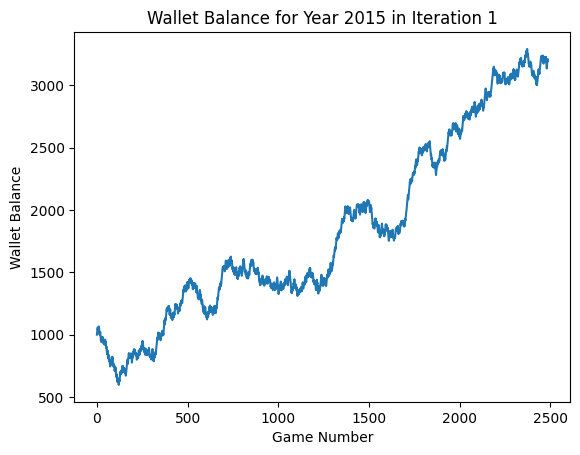

Minimum Wallet Balance: 596.9077325090908

Year: 2016
Final Wallet Balance: 2277.07988889215


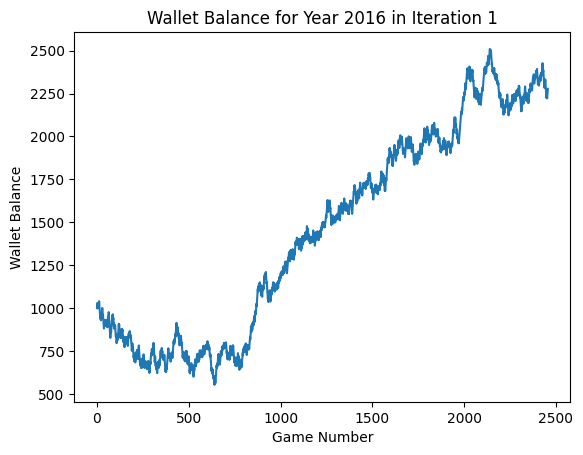

Minimum Wallet Balance: 552.0253859935498

Year: 2017
Final Wallet Balance: 3354.6803926994676


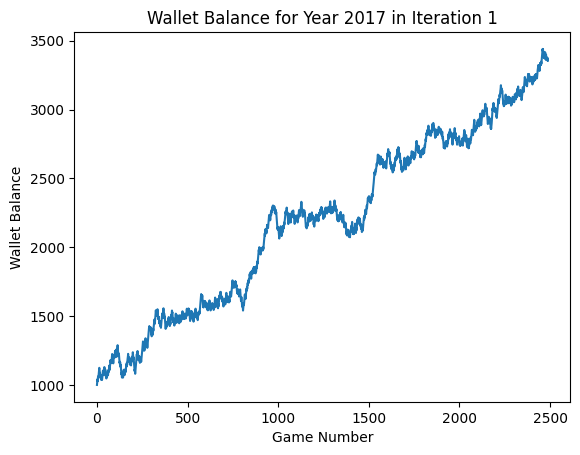

Minimum Wallet Balance: 1000

Year: 2018
Final Wallet Balance: 3745.3213048407642


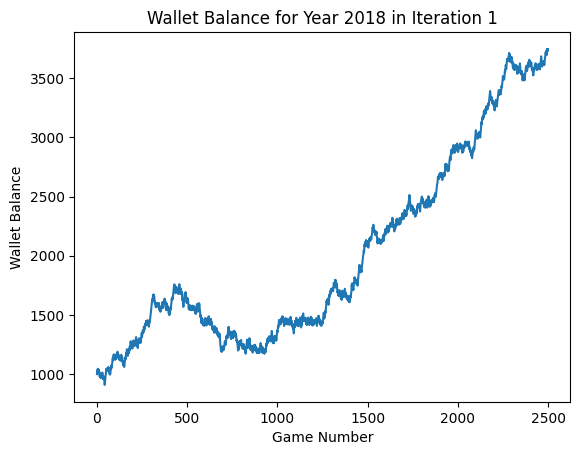

Minimum Wallet Balance: 908.7127675359676

Year: 2019
Final Wallet Balance: 5326.154803600376


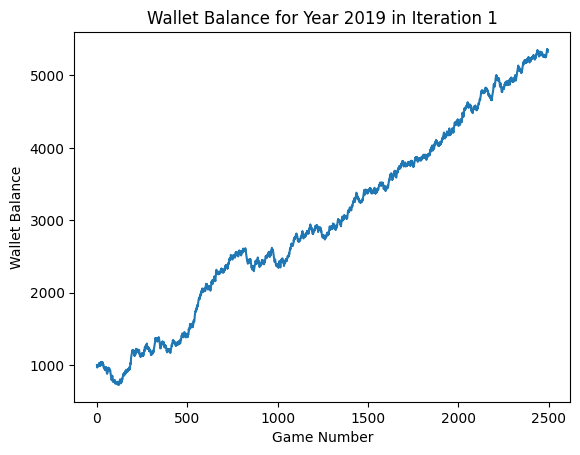

Minimum Wallet Balance: 725.4183358072405

Year: 2020
Final Wallet Balance: 2902.285465073486


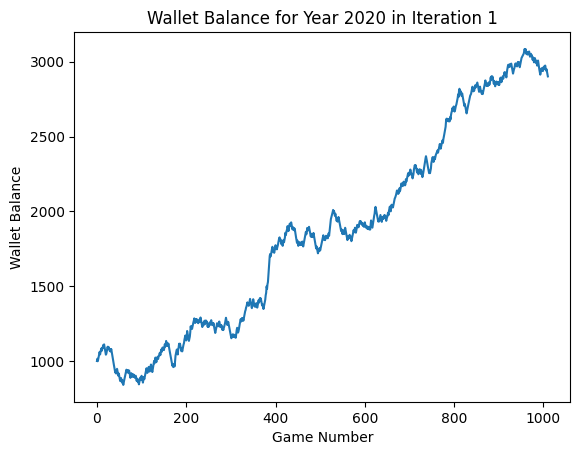

Minimum Wallet Balance: 840.2655941631773

Year: 2021
Final Wallet Balance: 5476.516385880178


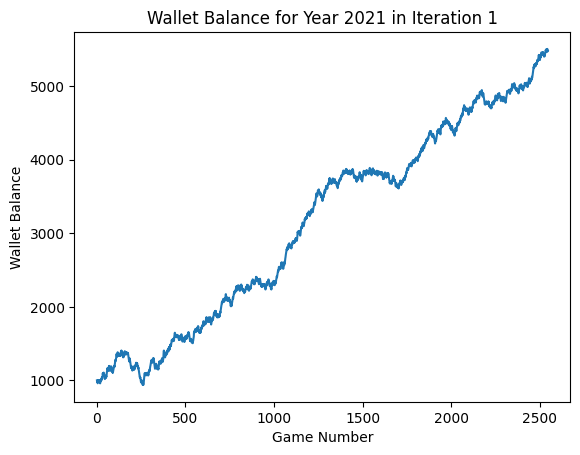

Minimum Wallet Balance: 938.1756638823664

Year: 2022
Final Wallet Balance: 6429.568857676549


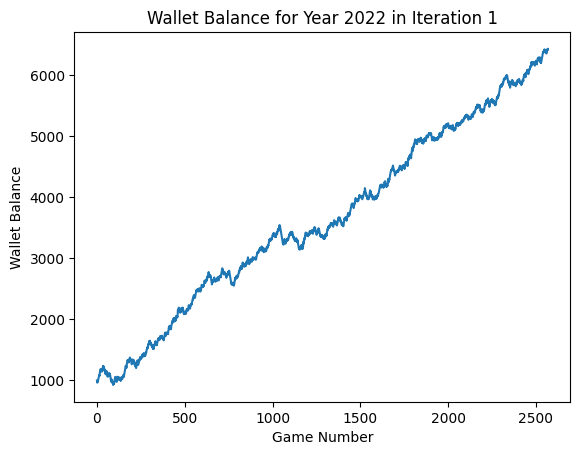

Minimum Wallet Balance: 926.2602561103585

Year: 2023
Final Wallet Balance: 4912.920876912586


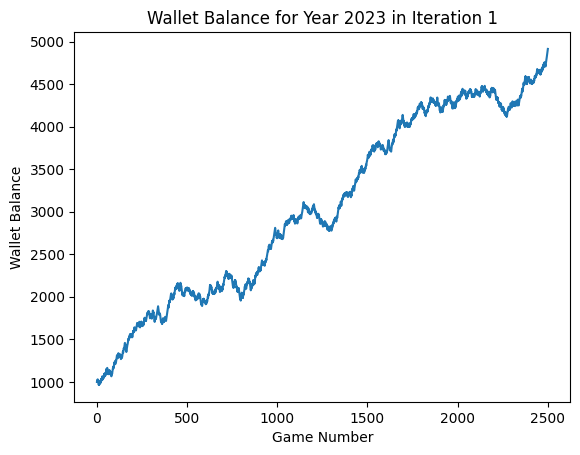

Minimum Wallet Balance: 963.5865136168221

Mean score of all years in Iteration 1: 0.5543242084328779
Year: 2015
Final Wallet Balance: 3193.2337656161467


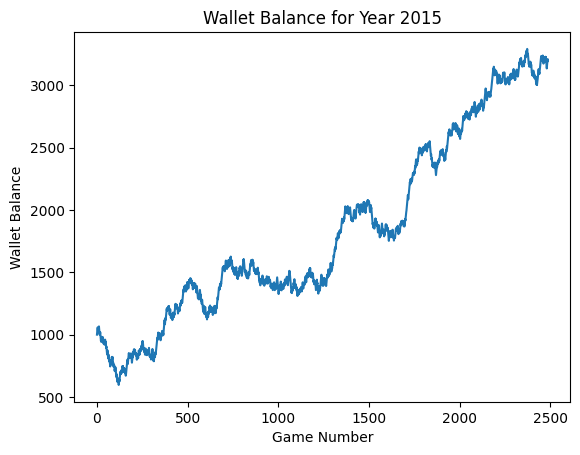

Minimum Wallet Balance: 596.9077325090908

Year: 2016
Final Wallet Balance: 2277.07988889215


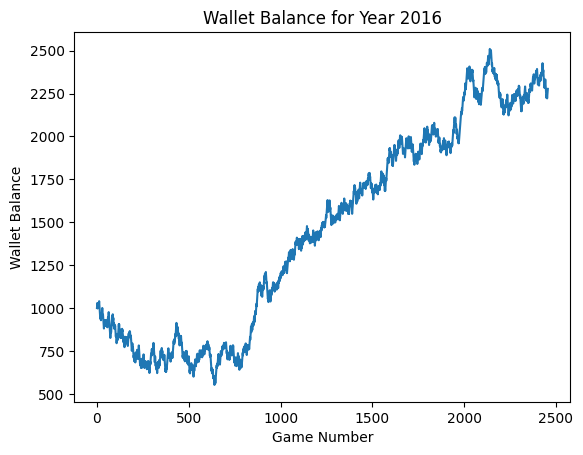

Minimum Wallet Balance: 552.0253859935498

Year: 2017
Final Wallet Balance: 3354.6803926994676


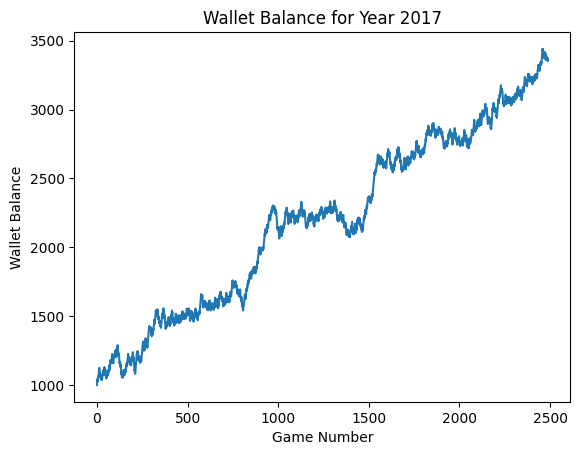

Minimum Wallet Balance: 1000

Year: 2018
Final Wallet Balance: 3745.3213048407642


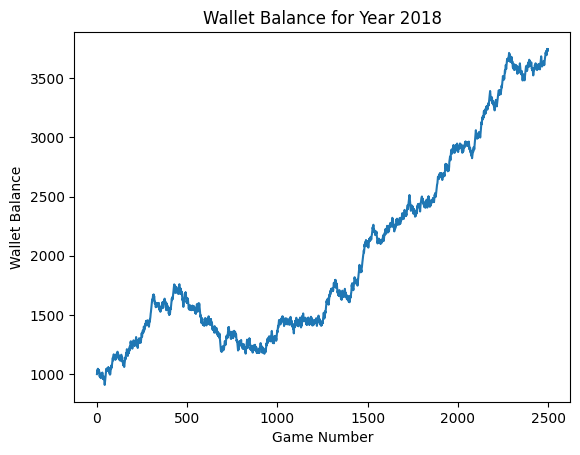

Minimum Wallet Balance: 908.7127675359676

Year: 2019
Final Wallet Balance: 5326.154803600376


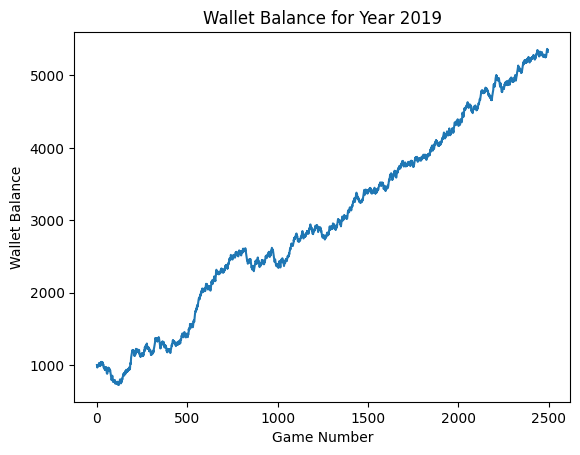

Minimum Wallet Balance: 725.4183358072405

Year: 2020
Final Wallet Balance: 2902.285465073486


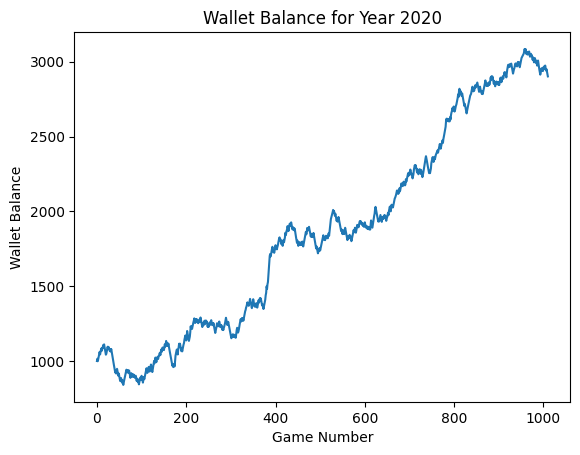

Minimum Wallet Balance: 840.2655941631773

Year: 2021
Final Wallet Balance: 5476.516385880178


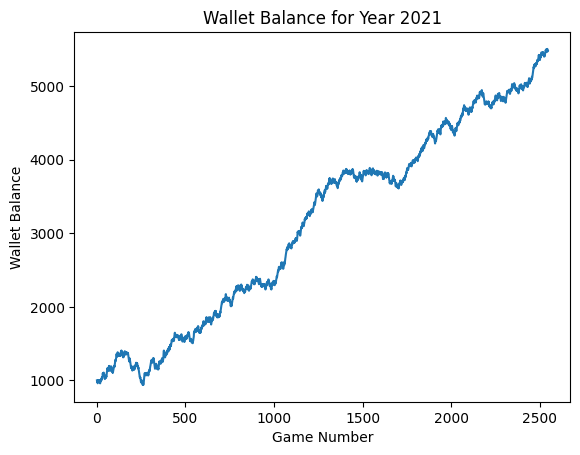

Minimum Wallet Balance: 938.1756638823664

Year: 2022
Final Wallet Balance: 6429.568857676549


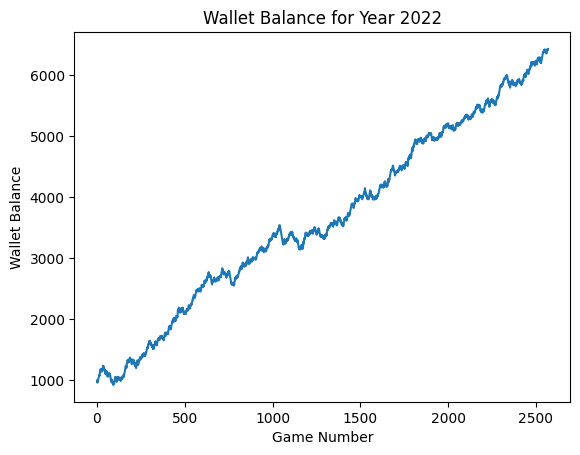

Minimum Wallet Balance: 926.2602561103585

Year: 2023
Final Wallet Balance: 4912.920876912586


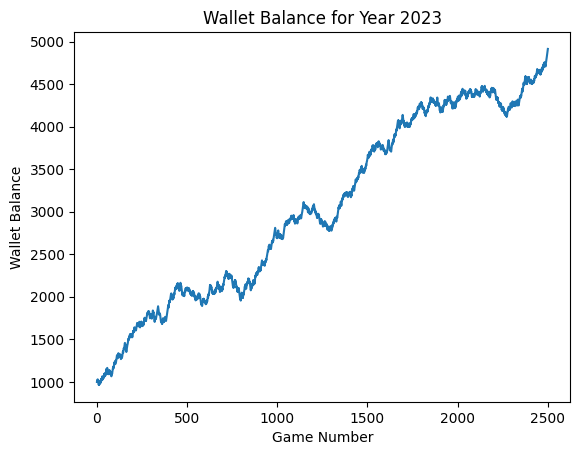

Minimum Wallet Balance: 963.5865136168221



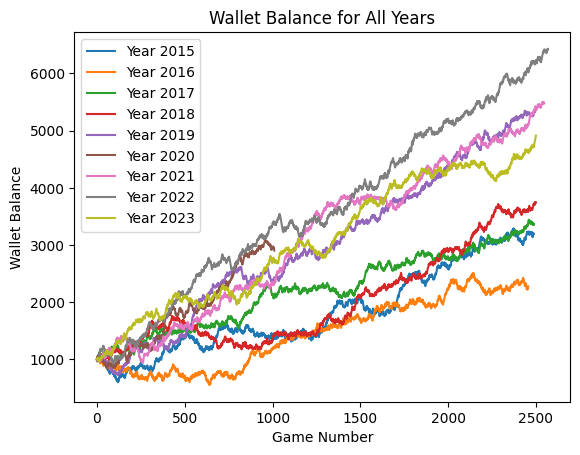

Cross-validation scores:  [0.5471976401179941, 0.573992133726647, 0.5478239488566511, 0.5308581263830834, 0.5438898450946644, 0.5665925376822337, 0.5215027187345527, 0.5286702916460702, 0.5538803756796836, 0.5669797330696985, 0.5532022188603126, 0.5356872635561161, 0.5596469104665825, 0.5480453972257251, 0.5470365699873897, 0.5622427983539094, 0.5488683127572016, 0.553897607409313, 0.5770517108309751, 0.5394906097247234, 0.54809670781893, 0.5349794238683128, 0.5442386831275721, 0.5713918188834577, 0.5505531258039619, 0.5450102880658436, 0.5444958847736625, 0.536522633744856, 0.5551839464882943, 0.58013892462053, 0.5672808486878839, 0.5713487852555152, 0.5562691985478917, 0.5758168109466629, 0.5551521921251047, 0.5509634180396538, 0.553755934096621, 0.5275062831611281, 0.5353253281206367, 0.5837988826815642, 0.5445406311086288, 0.5816810946662944, 0.5791678302150237, 0.5660430047472773, 0.5787709497206703, 0.5452310717797444, 0.553834808259587, 0.5384804524219327, 0.557905089746742, 0.5

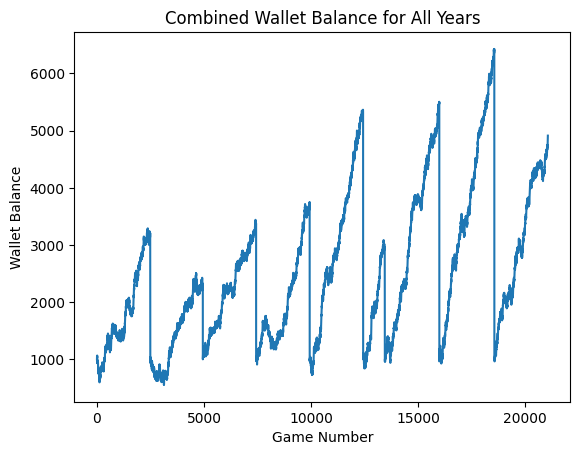

Maximum Wallet Balance: 37617.7617411917
Minimum Wallet Balance: 596.9077325090908


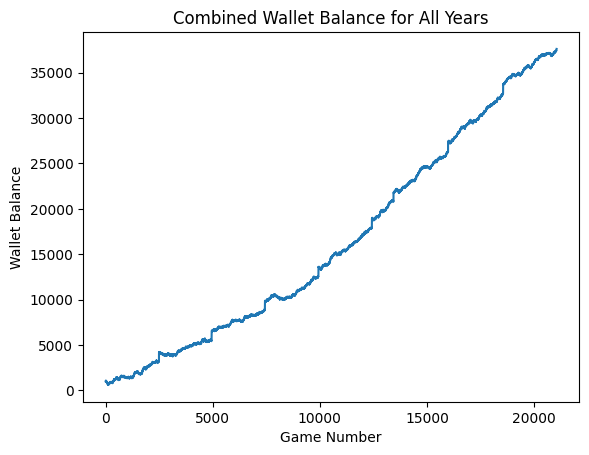

Year: 2015
Confusion Matrix:
[[ 276  838]
 [ 214 1101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.25      0.34      1114
           1       0.57      0.84      0.68      1315

    accuracy                           0.57      2429
   macro avg       0.57      0.54      0.51      2429
weighted avg       0.57      0.57      0.52      2429

Year: 2016
Confusion Matrix:
[[ 220  921]
 [ 169 1118]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.19      0.29      1141
           1       0.55      0.87      0.67      1287

    accuracy                           0.55      2428
   macro avg       0.56      0.53      0.48      2428
weighted avg       0.56      0.55      0.49      2428

Year: 2017
Confusion Matrix:
[[ 231  887]
 [ 173 1139]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.21      0.30      1118


KeyError: 'true_labels'

In [ ]:
display_results(all_results_9)
# for year, data in results.items():
#     print(f"Year: {year}")
#     print(f"Final Wallet Balance: {data['wallet']}")
#     plt.plot(data['wallet_history'])
#     plt.xlabel('Game Number')
#     plt.ylabel('Wallet Balance')
#     plt.title(f'Wallet Balance for Year {year}')
#     plt.show()
#     print(f"Minimum Wallet Balance: {min(data['wallet_history'])}\n")

# mean_scores = {}
# for year, data in results.items():
#     mean_scores[year] = np.mean(data['scores'])

# mean_of_all_years = np.mean(list(mean_scores.values()))

# #Combined wallet balance
# for year, data in results.items():
#     plt.plot(data['wallet_history'], label=f'Year {year}')

# plt.xlabel('Game Number')
# plt.ylabel('Wallet Balance')
# plt.title('Wallet Balance for All Years')
# plt.legend()
# plt.show()

# print("Cross-validation scores: ", scores)
# print("Cross-validation scores average: ", np.mean(scores))
# print("Standard deviation of cross-validation score: ", np.std(scores))
# print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



# # Initialize an empty list to store the combined wallet history
# combined_wallet_history = []

# # Loop over each year's data and extend the combined wallet history with each year's wallet history
# for data in results.values():
#     combined_wallet_history.extend(data['wallet_history'])

# # Plot the combined wallet balance over time
# plt.plot(combined_wallet_history)
# plt.xlabel('Game Number')
# plt.ylabel('Wallet Balance')
# plt.title('Combined Wallet Balance for All Years')
# plt.show()

# # Initialize an empty list to store the combined wallet history
# combined_wallet_history = []

# # Initialize a variable to store the ending balance of the previous year
# previous_year_end_balance = 0

# # Loop over each year's data
# for data in results.values():
#     # Add the ending balance of the previous year to the wallet history of the current year
#     adjusted_wallet_history = [balance + previous_year_end_balance for balance in data['wallet_history']]
    
#     # Extend the combined wallet history with the adjusted wallet history of the current year
#     combined_wallet_history.extend(adjusted_wallet_history)
    
#     # Update the ending balance of the previous year
#     previous_year_end_balance = adjusted_wallet_history[-1]

# # Print the maximum and minimum values of the combined wallet history
# print(f"Maximum Wallet Balance: {max(combined_wallet_history)}")
# print(f"Minimum Wallet Balance: {min(combined_wallet_history)}")

# # Plot the combined wallet balance over time
# plt.plot(combined_wallet_history)
# plt.xlabel('Game Number')
# plt.ylabel('Wallet Balance')
# plt.title('Combined Wallet Balance for All Years')
# plt.show()

# for year, data in results.items():
#     print(f"Year: {year}")
#     print("Confusion Matrix:")
#     print(data['conf_matrix'])
#     print("Classification Report:")
#     print(data['class_report'])

#     from sklearn.metrics import confusion_matrix, classification_report


# #
# # Initialize lists to store all true and predicted labels
# all_true_labels = []
# all_pred_labels = []

# # Loop over each year's data
# for data in results.values():
#     # Extend the lists with the true and predicted labels of the current year
#     all_true_labels.extend(data['true_labels'])
#     all_pred_labels.extend(data['pred_labels'])

# # Calculate the overall confusion matrix and classification report
# overall_conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
# overall_class_report = classification_report(all_true_labels, all_pred_labels)

# print("Overall Confusion Matrix:")
# print(overall_conf_matrix)
# print("Overall Classification Report:")
# print(overall_class_report)



In [ ]:

pd.set_option('display.max_columns', None)
test_purposes.head(1)

NameError: name 'test_purposes' is not defined

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
X_test

,HmStPchID_team_ID,HmStPchID_G,HmStPchID_GS,HmStPchID_RA,HmStPchID_xRA,HmStPchID_BIP,HmStPchID_BIP_perc,HmStPchID_ERA_plus,HmStPchID_WAR_rep,HmStPchID_WAA,HmStPchID_WAA_adj,HmStPchID_WAR,VisStPchID_team_ID,VisStPchID_G,VisStPchID_GS,VisStPchID_RA,VisStPchID_xRA,VisStPchID_BIP,VisStPchID_BIP_perc,VisStPchID_ERA_plus,VisStPchID_WAR_rep,VisStPchID_WAA,VisStPchID_WAA_adj,VisStPchID_WAR,HmBat1ID_team_ID,HmBat1ID_G,HmBat1ID_PA,HmBat1ID_runs_above_avg,HmBat1ID_runs_above_avg_off,HmBat1ID_runs_above_avg_def,HmBat1ID_WAR_rep,HmBat1ID_WAA,HmBat1ID_WAR,HmBat2ID_team_ID,HmBat2ID_G,HmBat2ID_PA,HmBat2ID_runs_above_avg,HmBat2ID_runs_above_avg_off,HmBat2ID_runs_above_avg_def,HmBat2ID_WAR_rep,HmBat2ID_WAA,HmBat2ID_WAR,HmBat3ID_team_ID,HmBat3ID_G,HmBat3ID_PA,HmBat3ID_runs_above_avg,HmBat3ID_runs_above_avg_off,HmBat3ID_runs_above_avg_def,HmBat3ID_WAR_rep,HmBat3ID_WAA,HmBat3ID_WAR,HmBat4ID_team_ID,HmBat4ID_G,HmBat4ID_PA,HmBat4ID_runs_above_avg,HmBat4ID_runs_above_avg_off,HmBat4ID_runs_above_avg_def,HmBat4ID_WAR_rep,HmBat4ID_WAA,HmBat4ID_WAR,HmBat5ID_team_ID,HmBat5ID_G,HmBat5ID_PA,HmBat5ID_runs_above_avg,HmBat5ID_runs_above_avg_off,HmBat5ID_runs_above_avg_def,HmBat5ID_WAR_rep,HmBat5ID_WAA,HmBat5ID_WAR,HmBat6ID_team_ID,HmBat6ID_G,HmBat6ID_PA,HmBat6ID_runs_above_avg,HmBat6ID_runs_above_avg_off,HmBat6ID_runs_above_avg_def,HmBat6ID_WAR_rep,HmBat6ID_WAA,HmBat6ID_WAR,HmBat7ID_team_ID,HmBat7ID_G,HmBat7ID_PA,HmBat7ID_runs_above_avg,HmBat7ID_runs_above_avg_off,HmBat7ID_runs_above_avg_def,HmBat7ID_WAR_rep,HmBat7ID_WAA,HmBat7ID_WAR,HmBat8ID_team_ID,HmBat8ID_G,HmBat8ID_PA,HmBat8ID_runs_above_avg,HmBat8ID_runs_above_avg_off,HmBat8ID_runs_above_avg_def,HmBat8ID_WAR_rep,HmBat8ID_WAA,HmBat8ID_WAR,HmBat9ID_team_ID,HmBat9ID_G,HmBat9ID_PA,HmBat9ID_runs_above_avg,HmBat9ID_runs_above_avg_off,HmBat9ID_runs_above_avg_def,HmBat9ID_WAR_rep,HmBat9ID_WAA,HmBat9ID_WAR,VisBat1ID_team_ID,VisBat1ID_G,VisBat1ID_PA,VisBat1ID_runs_above_avg,VisBat1ID_runs_above_avg_off,VisBat1ID_runs_above_avg_def,VisBat1ID_WAR_rep,VisBat1ID_WAA,VisBat1ID_WAR,VisBat2ID_team_ID,VisBat2ID_G,VisBat2ID_PA,VisBat2ID_runs_above_avg,VisBat2ID_runs_above_avg_off,VisBat2ID_runs_above_avg_def,VisBat2ID_WAR_rep,VisBat2ID_WAA,VisBat2ID_WAR,VisBat3ID_team_ID,VisBat3ID_G,VisBat3ID_PA,VisBat3ID_runs_above_avg,VisBat3ID_runs_above_avg_off,VisBat3ID_runs_above_avg_def,VisBat3ID_WAR_rep,VisBat3ID_WAA,VisBat3ID_WAR,VisBat4ID_team_ID,VisBat4ID_G,VisBat4ID_PA,VisBat4ID_runs_above_avg,VisBat4ID_runs_above_avg_off,VisBat4ID_runs_above_avg_def,VisBat4ID_WAR_rep,VisBat4ID_WAA,VisBat4ID_WAR,VisBat5ID_team_ID,VisBat5ID_G,VisBat5ID_PA,VisBat5ID_runs_above_avg,VisBat5ID_runs_above_avg_off,VisBat5ID_runs_above_avg_def,VisBat5ID_WAR_rep,VisBat5ID_WAA,VisBat5ID_WAR,VisBat6ID_team_ID,VisBat6ID_G,VisBat6ID_PA,VisBat6ID_runs_above_avg,VisBat6ID_runs_above_avg_off,VisBat6ID_runs_above_avg_def,VisBat6ID_WAR_rep,VisBat6ID_WAA,VisBat6ID_WAR,VisBat7ID_team_ID,VisBat7ID_G,VisBat7ID_PA,VisBat7ID_runs_above_avg,VisBat7ID_runs_above_avg_off,VisBat7ID_runs_above_avg_def,VisBat7ID_WAR_rep,VisBat7ID_WAA,VisBat7ID_WAR,VisBat8ID_team_ID,VisBat8ID_G,VisBat8ID_PA,VisBat8ID_runs_above_avg,VisBat8ID_runs_above_avg_off,VisBat8ID_runs_above_avg_def,VisBat8ID_WAR_rep,VisBat8ID_WAA,VisBat8ID_WAR,VisBat9ID_team_ID,VisBat9ID_G,VisBat9ID_PA,VisBat9ID_runs_above_avg,VisBat9ID_runs_above_avg_off,VisBat9ID_runs_above_avg_def,VisBat9ID_WAR_rep,VisBat9ID_WAA,VisBat9ID_WAR
Game_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20110331CINMIL,110.625000,18.375000,17.062500,51.812500,47.099438,291.437500,0.066450,86.927993,0.876481,-0.381725,-0.061137,0.434375,101.230769,24.538462,23.615385,67.538462,67.208923,420.923077,0.095192,104.840765,1.251592,0.303815,-0.076062,1.479231,68.000000,75.916667,263.916667,-1.375000,0.050000,-0.725000,0.820000,-0.159167,0.660833,43.555556,105.666667,444.000000,2.638889,1.561111,3.850000,1.3600

In [ ]:
view_data(per_game_data_reduced)

There are no NaN values in the dataset


: 

> c:\users\vile3\appdata\roaming\python\python39\site-packages\ipython\core\interactiveshell.py(2436)run_line_magic()
   2434             extra = '' if cm is None else (' (But cell magic `%%%%%s` exists, '
   2435                                     'did you mean that instead?)' % magic_name )
-> 2436             raise UsageError(etpl % (magic_name, extra))
   2437         else:
   2438             # Note: this is the distance in the stack to the user's frame.

